# ASPA analysis notebook

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
#import ptitprince as pt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from Bio import AlignIO
import warnings
import mdtraj as md
from pylab import *
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import roc_curve, auc
from scipy.stats import bootstrap
import itertools
warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [3]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_L_D_reordered={0:'R',1:'H',2:'K',3:'D',4:'E',5:'S',6:'T',7:'N',8:'Q',9:'C',10:'G',11:'P',12:'A',13:'V',14:'I',15:'L',16:'M',17:'F',18:'Y',19:'W'}
alphabetAA_D_D_reordered={14:0,6:1,8:2,2:3,3:4,15:5,16:6,11:7,13:8,1:9,5:10,12:11,0:12,17:13,7:14,9:15,10:16,4:17,19:18,18:19}

In [4]:
def pearson_output(x,y):
    return sp.stats.pearsonr(x,y)[0]

In [5]:
def spearman_output(x,y):
    return sp.stats.spearmanr(x,y)[0]

In [6]:
def df_to_score(df,column_score,wt_seq,mutation_column='variant',idx_gap=0,is_residue=False):
    mutation_load=df[mutation_column].to_numpy()
    score_load=df[column_score].to_numpy()
    if is_residue:
        score_out=np.empty(len(wt_seq),dtype=float)
    else:
        score_out=np.empty((len(wt_seq),20),dtype=float)
        
    score_out[:]=np.nan
    for idx,(var,score) in enumerate(zip(mutation_load,score_load)):
        if is_residue:
            if var[-1]== '=':
                score_out[int(var[1:-1])-1+idx_gap]=float(score)
        else:
            if  var[-1]!= '=':
                score_out[int(var[1:-1])-1+idx_gap, alphabetAA_L_D[var[-1]]-1]= float(score)
    return score_out

In [7]:
def heatmap_scores_reordered(ext_score,label_cm,WT_mask,lim_down,lim_up,color,x,WT_cmap='gnuplot_r',nan_cmap='Dark2_r',figs=[30,7],xtick_spacing=10):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20

    score=np.copy(ext_score)

    for i in range(score.shape[1]):
        #print(i,score[:,i][0:10])
        score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
        #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

    score_nan=np.copy(ext_score)
    score_nan[:]=np.inf
    
    for i in range(score.shape[0]):
        for j in range(score.shape[1]):
                if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:
                    
                    score_nan[i,alphabetAA_D_D_reordered[j]]=1
                    #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])
            
    fig, ax = plt.subplots(figsize=(figs[0],figs[1]))
    ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
 
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                 vmin=lim_down,vmax=lim_up,interpolation='nearest')
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    
    #ax.xaxis.set_ticks(np.arange(1, end, stepsize))

    plt.grid(axis='both',which='both',alpha=0.4)
    #plt.ylabel("mutation")
    plt.xlabel("Position")
    plt.ylim(-0.5,19.5)
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1
    
    print(score_nan[0,:])
    plt.imshow(score_nan.T, cmap=nan_cmap, aspect = 'auto',interpolation='nearest')
    plt.imshow(tmp.T, cmap=WT_cmap, aspect = 'auto',interpolation='nearest')
    

In [8]:
def correlation_plot(x,y,x_label='score1',y_label='score2',nan_value=-99999,max=-99999):
    

    
    def func(x, a, b):
        return a * x + b
    
    rng = np.random.default_rng()
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))    
    
    bad = ~np.logical_or(np.isnan(x), np.isnan(y)) 
    
    x_t=np.compress(bad, x)
    y_t=np.compress(bad, y)

    xy= np.vstack([x_t,y_t])
    z = sp.stats.gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    
    ax.grid(alpha=0.3)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    
    
    x_s, y_s, z = x_t[idx], y_t[idx], z[idx]
    surf= ax.scatter(x_s, y_s, c=z, s=100,cmap='viridis')
        
    #stats

    
    print("spearman's r:", spearman_output(x_s,y_s))
    
    #correlation line    
#     optimizedParameters, pcov = curve_fit(func, x_s, y_s);
    
#     ax.plot(x_s,func(x_s, *optimizedParameters),'r' ,label="fit" )
    
    ## bootstrap statistic
    
    res = bootstrap((x_s, y_s), spearman_output, vectorized=False, paired=True,
                random_state=rng)
    
    print("boostraping confidence interval:", res.confidence_interval)
    

In [9]:
def hexbin_correlation_plot(x,y,x_label='score1',y_label='score2',bins=None,cmap="viridis"):
    
    mpl.rcParams['xtick.labelsize'] = 19
    mpl.rcParams['ytick.labelsize'] = 19
    mpl.rcParams['axes.labelsize']  = 19
    mpl.rcParams['legend.fontsize'] = 19
    
    rng = np.random.default_rng()
    
    fig, ax = plt.subplots(1,1,figsize=(8,6))    
    
    bad = ~np.logical_or(np.isnan(x), np.isnan(y)) 
    
    x_t=np.compress(bad, x)
    y_t=np.compress(bad, y)
    
    #m = ax.hexbin(x_t,y_t,C=None,mincnt=1,gridsize=100,bins=bins)
    m = ax.hexbin(x_t,y_t,C=None,mincnt=1,gridsize=100,bins=bins,cmap=cmap)
    
    cbar = fig.colorbar(m,label='Number of data points')
    cbar.set_label('Number of data points')
    
    ax.grid(alpha=0.3)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
      
    ## stats
    
    print("spearman's r:", spearman_output(x_t,y_t))
    
    ## bootstrap statistic
    
    res = bootstrap((x_t, y_t), spearman_output, vectorized=False, paired=True,
               random_state=rng)
    
    print("boostraping confidence interval:", res.confidence_interval)

In [10]:
def heatmap_classification_WT(ext_score,WT_seq,x,region_spec='all',color_spec=[],ticks_label_start=1,ticks_spacing=10,fig_size=[40,10]):
# Plot the heatmap of the input color based classification matrix
# It's possible to plot only one of the region using the region number
# It's mandatory for the single region plot to assign a color using a list with two colors

    score=np.copy(ext_score)
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=5
    
    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]

    #plot of the entire classification heatmap with the current color scheme.
    if region_spec=='all':
        ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442","#56b4e9", "#009e74","#5A5A5A"]),interpolation='nearest')

    # this part manages the plot of specific region, the other one are set to 0 and the designed region is set to 1 (binary map) 
    else:
        for i in range(score.shape[0]):
            for j in range(score.shape[1]):
                if np.isnan(score[i,j]) == True:
                    pass
                else:
                    if score[i,j] == region_spec:
                        score[i,j]=1
                    else:
                        score[i,j]=0
        for i in range(len(WT_seq)):
            score[i,alphabetAA_L_D[WT_seq[i]]-1]=2
        ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(color_spec))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation")
    plt.xlabel("residue")

    plt.ylim(-0.5,19.5)
    
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    print(start,end)
    
    ax.xaxis.set_ticks(np.arange(start+0.5, end, ticks_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)

    xlabels= np.arange(ticks_label_start, ticks_label_start+(end-start), ticks_spacing,dtype=int)
    ax.set_xticklabels(xlabels)


In [11]:
def scatter(x,y,xerr,yerr,dataframe,x_name,y_name,filename):
    
    fig, ax = plt.subplots(figsize=(6,5))

    ax.errorbar(dataframe[x],dataframe[y],
                xerr=dataframe[xerr],yerr=dataframe[yerr],
                fmt='s',elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

    label_single=dataframe['variant'].to_list()
    for i, label in enumerate(label_single):
        ax.annotate(label, (dataframe[x][i]+0.02,dataframe[y][i]-0.1), fontsize = 12)

    ax.set_xlabel(x_name,fontsize=16)
    ax.set_ylabel(y_name,fontsize=16)

    plt.tight_layout()
    #plt.savefig(f'Figures/{filename}')
    plt.savefig(f'updated_figures/{filename}')

In [12]:
#Custom color map
Wistia = mpl.cm.get_cmap('YlOrBr', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp = ListedColormap(newcolors)

In [13]:
#Custom color map
Wistia = mpl.cm.get_cmap('Blues', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp2 = ListedColormap(newcolors)

## Loading Datasets
### WT sequence

In [16]:
ASPA_WT_sequence="MTSCHIAEEHIQKVAIFGGTHGNELTGVFLVKHWLENGAEIQRTGLEVKPFITNPRAVKKCTRYIDCDLNRIFDLENLGKKMSEDLPYEVRRAQEINHLFGPKDSEDSYDIIFDLHNTTSNMGCTLILEDSRNNFLIQMFHYIKTSLAPLPCYVYLIEHPSLKYATTRSIAKYPVGIEVGPQPQGVLRADILDQMRKMIKHALDFIHHFNEGKEFPPCAIEVYKIIEKVDYPRDENGEIAAIIHPNLQDQDWKPLHPGDPMFLTLDGKTIPLGGDCTVYPVFVNEAAYYEKKEAFAKTTKLTLNAKSIRCCLH"
ASPA_WT_2o53_seq="--------EHIQKVAIFGGTHGNELTGVFLVKHWLENGAEIQRTGLEVKPFITNPRAVKKCTRYIDCDLNRIFDLENLGKKMSEDLPYEVRRAQEINHLFGPKDSEDSYDIIFDLHNTTSNMGCTLILEDSRNNFLIQMFHYIKTSLAPLPCYVYLIEHPSLKYATTRSIAKYPVGIEVGPQPQGVLRADILDQMRKMIKHALDFIHHFNEGKEFPPCAIEVYKIIEKVDYPRDENGEIAAIIHPNLQDQDWKPLHPGDPMFLTLDGKTIPLGGDCTVYPVFVNEAAYYEKKEAFAKTTKLTLNAKSIRC---"

In [17]:
len(ASPA_WT_sequence)

313

### Load DF data

In [18]:
df_input=pd.read_excel('./aspa_suppl4_preprint.xlsx',index_col=0,sheet_name='variants_data')

In [19]:
df_input.head()

variant  abundance_score  abundance_std  tox_score  tox_std  gemme_de  \
0     M1A              NaN            NaN        NaN      NaN -1.006358   
1     M1C              NaN            NaN        NaN      NaN -1.006358   
2     M1D              NaN            NaN        NaN      NaN -0.904105   
3     M1E              NaN            NaN        NaN      NaN -0.904105   
4     M1F              NaN            NaN        NaN      NaN -1.006358   

   normalized_rosetta_ddg_monomer_Zn  normalized_rosetta_ddg_dimer_Zn  \
0                                NaN                              NaN   
1                                NaN                              NaN   
2                                NaN                              NaN   
3                                NaN                              NaN   
4                                NaN                              NaN   

   wcn_sidechains_AF   degrons  QCDPred  AF_confidence Clinvar  \
0           0.742631  2.936204      0.0          44.53     NaN   
1           0.742631  2.936204      0.0          44.53     NaN   
2           0.742631  2.936204      0.0          44.53     NaN   
3           0.742631  2.936204      0.0          44.53     NaN   
4           0.742631  2.936204      0.0          44.53     NaN   

   gnomAD_allele_frequency  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN

In [20]:
df_stop=pd.read_excel('./aspa_suppl4_preprint.xlsx',index_col=0,sheet_name='stop_variants')

In [21]:
df_syn=pd.read_excel('./aspa_suppl4_preprint.xlsx',index_col=0,sheet_name='syn_variants')

In [22]:
df_stop_tox=pd.read_excel('./aspa_suppl4_preprint.xlsx',index_col=0,sheet_name='stop_variants_tox')

In [23]:
df_syn_tox=pd.read_excel('./aspa_suppl4_preprint.xlsx',index_col=0,sheet_name='syn_variants_tox')

In [24]:
df_hsp70=pd.read_excel('./aspa_suppl4_preprint.xlsx',sheet_name='hsp70_expression_data')

### Load Abudance data

In [25]:
ASPA_scores=df_to_score(df_input,'abundance_score',ASPA_WT_sequence)

In [26]:
ASPA_scores_err=df_to_score(df_input,'abundance_std',ASPA_WT_sequence)

In [27]:
ASPA_scores_med=np.nanmedian(ASPA_scores,axis=1)

In [28]:
ASPA_stop_scores=df_stop['abundance_score'].to_numpy().flatten()

In [29]:
ASPA_stop_scores_err=df_stop['abundance_std'].to_numpy().flatten()

In [30]:
ASPA_syn_scores=np.array([i for i in df_syn['abundance_score'] if np.isnan(i)==False])

In [31]:
ASPA_syn_scores_med=np.nanmedian(ASPA_syn_scores)

In [32]:
ASPA_syn_scores_min=np.nanmin(ASPA_syn_scores)

### Degron experimental

In [33]:
ASPA_degron_residues=df_to_score(df_input,'degrons',ASPA_WT_sequence)

In [34]:
_,idx=np.unique(ASPA_degron_residues[~np.isnan(ASPA_degron_residues[:,0])][:,0],return_index=True)
ASPA_degron_tiles=ASPA_degron_residues[~np.isnan(ASPA_degron_residues[:,0])][:,0][np.sort(idx)]

### Low throughput variants

In [35]:
df_low_t=pd.read_excel('./aspa_suppl4_preprint.xlsx',sheet_name='low_throughput_variants')

In [36]:
df_low_t

variant  fluorescence_low_score  fluorescence_low_std
0       WT                1.000000              0.000000
1     F29H                1.283905              0.060216
2     N54K                0.663614              0.134840
3     M82T                1.136476              0.083476
4    D114Y                0.882739              0.078246
5    C152W                0.166298              0.089473
6    K163L                1.069307              0.162737
7    E235K                1.093572              0.132958
8    L263S                0.892563              0.097455
9    E285A                1.193138              0.127239
10   A305E                0.188772              0.077644
11   L312D                1.339623              0.221657
12    T26V                0.274893              0.006817
13   N121Q                0.691659              0.022284
14   A219L                0.840836              0.027568
15   P254F                0.167246              0.005763
16   P257T                0.608963              0.017785
17   P260E                0.795014              0.021853

In [37]:
temp_score=[]
temp_std=[]
for i in df_low_t['variant']:
    if i !='WT':
        temp_score.append(ASPA_scores[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1])
        temp_std.append(ASPA_scores_err[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1])

    else:
        temp_score.append(1.0)
        temp_std.append(0.0)

In [38]:
df_low_t['abundance_score']=temp_score
df_low_t['abundance_std']=temp_std

### Toxicity

In [39]:
ASPA_toxicity_score=df_to_score(df_input,'tox_score',ASPA_WT_sequence)

In [40]:
ASPA_toxicity_err=df_to_score(df_input,'tox_std',ASPA_WT_sequence)

In [41]:
ASPA_toxicity_med=np.nanmedian(ASPA_toxicity_score,axis=1)

In [42]:
ASPA_toxicity_stop_scores = np.zeros(len(ASPA_WT_sequence))
ASPA_toxicity_stop_scores[:] = np.nan
resi = np.array([int(resi[1:-1]) for resi in df_stop_tox.index.values])
ASPA_toxicity_stop_scores[resi - 1] = df_stop_tox['tox_score'].to_numpy().flatten()

In [43]:
ASPA_toxicity_stop_scores_err = np.zeros(len(ASPA_WT_sequence))
ASPA_toxicity_stop_scores_err[:] = np.nan
resi = np.array([int(resi[1:-1]) for resi in df_stop_tox.index.values])
ASPA_toxicity_stop_scores_err[resi - 1] = df_stop_tox['tox_std'].to_numpy().flatten()

In [44]:
ASPA_toxicity_syn_scores=np.array([i for i in df_syn_tox['tox_score'] if np.isnan(i)==False])
ASPA_toxicity_syn_scores = ASPA_toxicity_syn_scores[1:]

In [45]:
ASPA_toxicity_syn_scores_med=np.nanmedian(ASPA_toxicity_syn_scores)

In [46]:
ASPA_toxicity_syn_scores_min=np.nanmin(ASPA_toxicity_syn_scores)

In [47]:
# add tox data to df_low_t with low-throughput measurements of abundance
df_low_t_tox = df_low_t.merge(df_input[["variant","tox_score","tox_std"]],how="left",left_on="variant",right_on="variant")

### HSP70 expression

In [48]:
df_hsp70 = df_hsp70.rename(columns={'Variant':'variant','Mean':'hsp70_mean','Standard deviation of population':'hsp70_std'})
hsp70_low_t_tox_df = df_hsp70.merge(df_low_t_tox,how="left",left_on="variant",right_on="variant")

### Load computational data
#### Rosetta Scores ASPA

In [49]:
normalized_rosetta_ASPA_monomer_ZN=df_to_score(df_input,'normalized_rosetta_ddg_monomer_Zn',ASPA_WT_sequence)

In [50]:
normalized_rosetta_ASPA_monomer_ZN_avg=np.nanmedian(normalized_rosetta_ASPA_monomer_ZN,axis=1)

In [51]:
normalized_rosetta_ASPA_dimer=df_to_score(df_input,'normalized_rosetta_ddg_dimer_Zn',ASPA_WT_sequence)

In [52]:
normalized_rosetta_ASPA_dimer_avg=np.nanmedian(normalized_rosetta_ASPA_dimer,axis=1)

#### GEMME score

In [53]:
GEMME_ASPA_scores=df_to_score(df_input,'gemme_de',ASPA_WT_sequence)

In [54]:
GEMME_ASPA_scores_med=np.nanmedian(GEMME_ASPA_scores,axis=1)

#### confidence score

In [55]:
ASPA_confidence_score=df_to_score(df_input,'AF_confidence',ASPA_WT_sequence,is_residue=True)

#### wcn 

In [56]:
ASPA_wcn=df_to_score(df_input,'wcn_sidechains_AF',ASPA_WT_sequence,is_residue=True)

In [57]:
ASPA_wcn_tile=[]
for i in range((len(ASPA_WT_sequence)//12)):
    if i<23:
        ASPA_wcn_tile.append(np.median(ASPA_wcn[0+i*12:24+i*12]))
    else:
        ASPA_wcn_tile.append(np.median(ASPA_wcn[0+i*12:]))


#### degron QCDpred

In [58]:
ASPA_QCDpred_residue=df_to_score(df_input,'QCDPred',ASPA_WT_sequence,is_residue=True)

### Gnomad and Clinvar variants

In [59]:
gnomad_ASPA_freq_db_matrix=df_to_score(df_input,'gnomAD_allele_frequency',ASPA_WT_sequence)

In [60]:
mutation_load=df_input['variant'].to_list()
clinvar_status=df_input['Clinvar'].to_list()

clinvar_ASPA_db_matrix=np.empty((len(ASPA_WT_sequence),20),dtype=float)
clinvar_ASPA_db_matrix[:]=np.nan

for idx,(var,class_clin) in enumerate(zip(mutation_load,clinvar_status)):
    if class_clin=="benign":
        clinvar_ASPA_db_matrix[int(var[1:-1])-1,alphabetAA_L_D[var[-1]]-1]=0    
    if class_clin=="pathogenic":
        clinvar_ASPA_db_matrix[int(var[1:-1])-1,alphabetAA_L_D[var[-1]]-1]=1
    if class_clin=="VUS":
        clinvar_ASPA_db_matrix[int(var[1:-1])-1,alphabetAA_L_D[var[-1]]-1]=2

#### df clinical variants

In [61]:
mutation_disease=[]
extract_disease=[]
extract_mave=[]
extract_gemme=[]
extract_ddg=[]
extract_gnomad=[]
extract_AFidr=[]
extract_wcn=[]
extract_QCDPred=[]
extract_degrons=[]
extract_toxicity=[]

for i in range(clinvar_ASPA_db_matrix.shape[0]):
    for j in range(clinvar_ASPA_db_matrix.shape[1]):
        if np.isnan(clinvar_ASPA_db_matrix[i,j]):
            pass
        else:
            mutation_disease.append(ASPA_WT_sequence[i]+str(i+1)+alphabetAA_D_L[j+1])
            if  clinvar_ASPA_db_matrix[i,j]==0:
                extract_disease.append('benign')
            elif clinvar_ASPA_db_matrix[i,j] == 1:
                extract_disease.append('pathogenic')
            elif clinvar_ASPA_db_matrix[i,j] == 2:
                extract_disease.append('VUS')
            
            if np.isnan(gnomad_ASPA_freq_db_matrix[i,j]):
                extract_gnomad.append(np.inf)
            else:
                extract_gnomad.append(gnomad_ASPA_freq_db_matrix[i,j])
            extract_mave.append(ASPA_scores[i,j])
            extract_gemme.append(GEMME_ASPA_scores[i,j])
            extract_ddg.append(normalized_rosetta_ASPA_dimer[i,j])
            extract_AFidr.append(ASPA_confidence_score[i])
            extract_wcn.append(ASPA_wcn[i])
            extract_QCDPred.append(ASPA_QCDpred_residue[i])
            extract_degrons.append(ASPA_degron_residues[i])
            extract_toxicity.append(ASPA_toxicity_score[i,j])

In [62]:
df_disease= pd.DataFrame({'mutation': mutation_disease,
                          'disease':extract_disease ,
                          'mave':extract_mave,
                          'toxicity':extract_toxicity,
                          'gemme': extract_gemme,
                          'ddg_AF':extract_ddg,
                          'wcn':extract_wcn,
                          'TSI':extract_degrons,
                          'QCDPred':extract_QCDPred,
                          'freq_gnomad':extract_gnomad,
                          'AF_confidence':extract_AFidr})


## Analysis

### Experimental heatmaps

N.B. the color scale here are not adjusted as in the paper figure from 0 to 1.5., but they are from 0 to 2

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


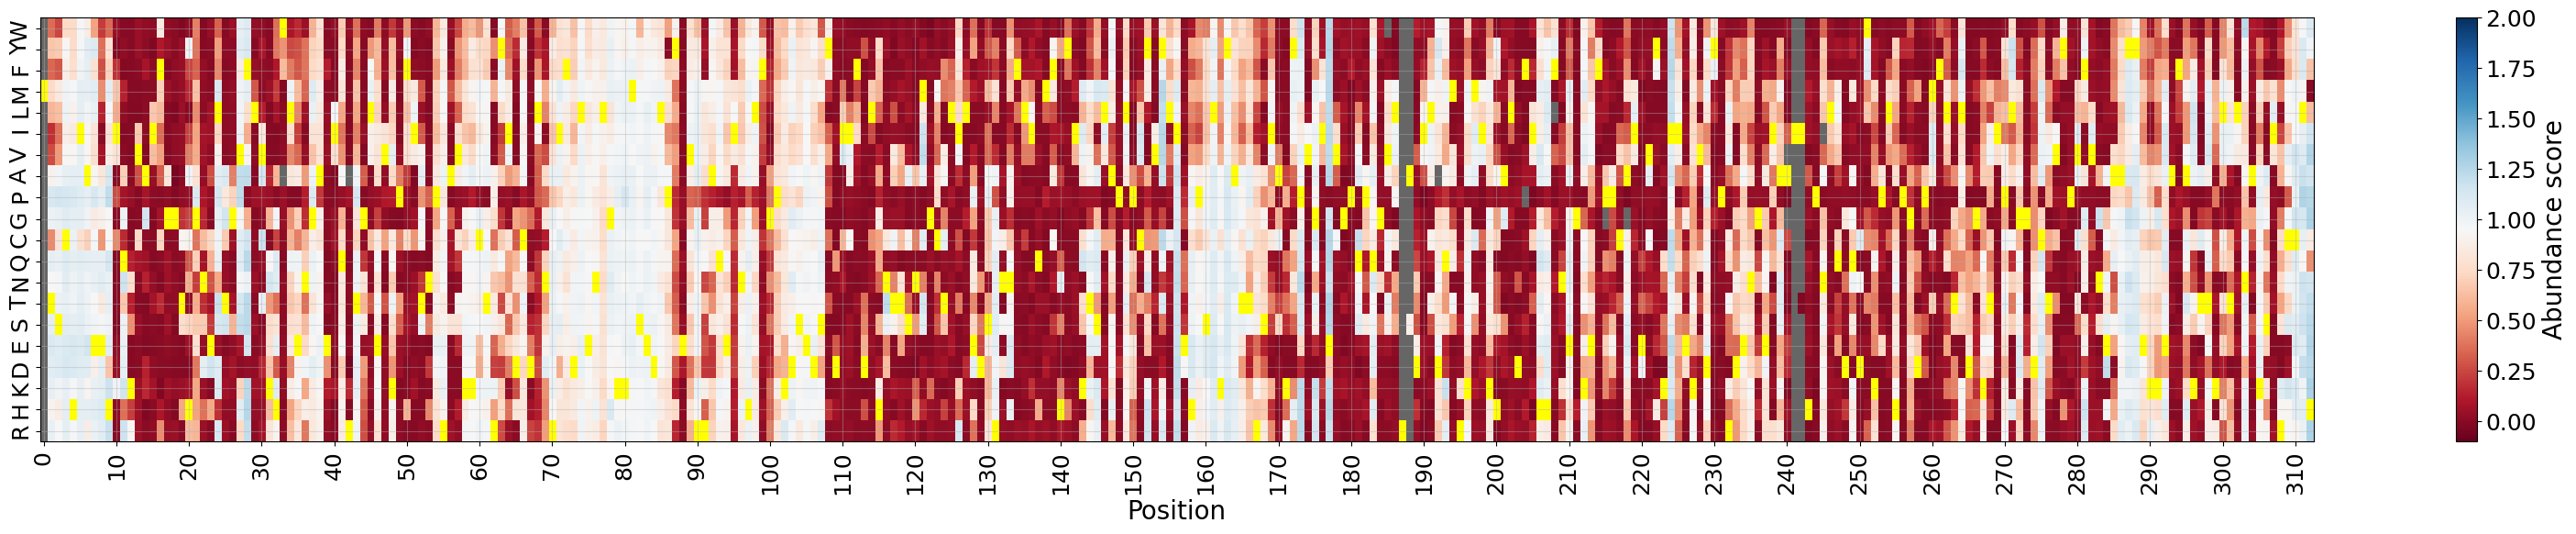

In [61]:
heatmap_scores_reordered(ASPA_scores,'Abundance score',ASPA_WT_sequence,2,0,'RdBu',[0,len(ASPA_WT_sequence)-1],figs=[40,6])
plt.savefig('./Figures//ASPA_heatmap_MAVE_all_reordered.pdf',dpi=300, facecolor='w')

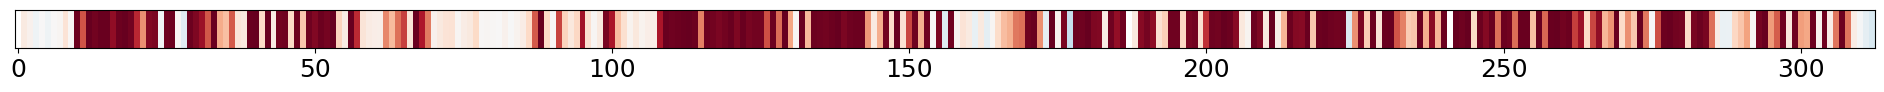

In [288]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(ASPA_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(ASPA_WT_sequence)+.5-1)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('./Figures//ASPA_heamap_MAVE_med.pdf',dpi=300, facecolor='w')

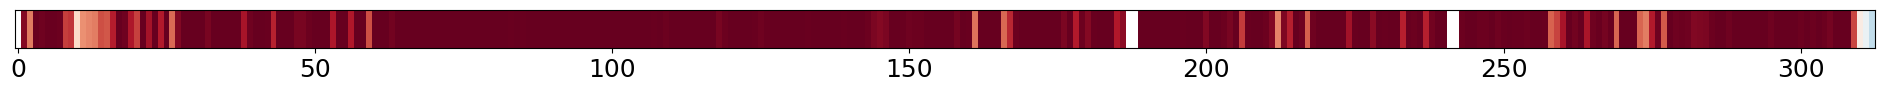

In [289]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(ASPA_stop_scores.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(ASPA_WT_sequence)+.5-1)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('./Figures//ASPA_heamap_MAVE_stop_2.pdf',dpi=300, facecolor='w')

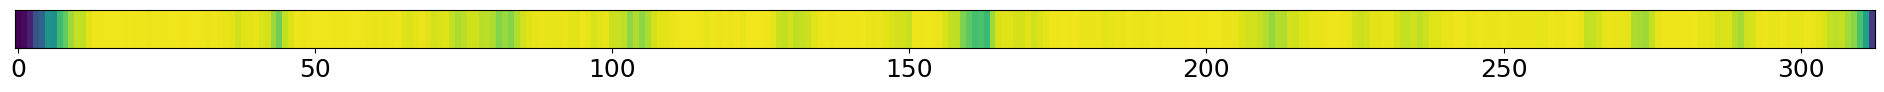

In [290]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(ASPA_confidence_score.reshape(1,-1),aspect= 'auto',cmap='viridis',vmin=50,vmax=100,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(ASPA_WT_sequence)+.5-1)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('./Figures//ASPA_heamap_pLDDT.pdf',dpi=300, facecolor='w')

### Computational protocols heatmaps
#### GEMME scores

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]


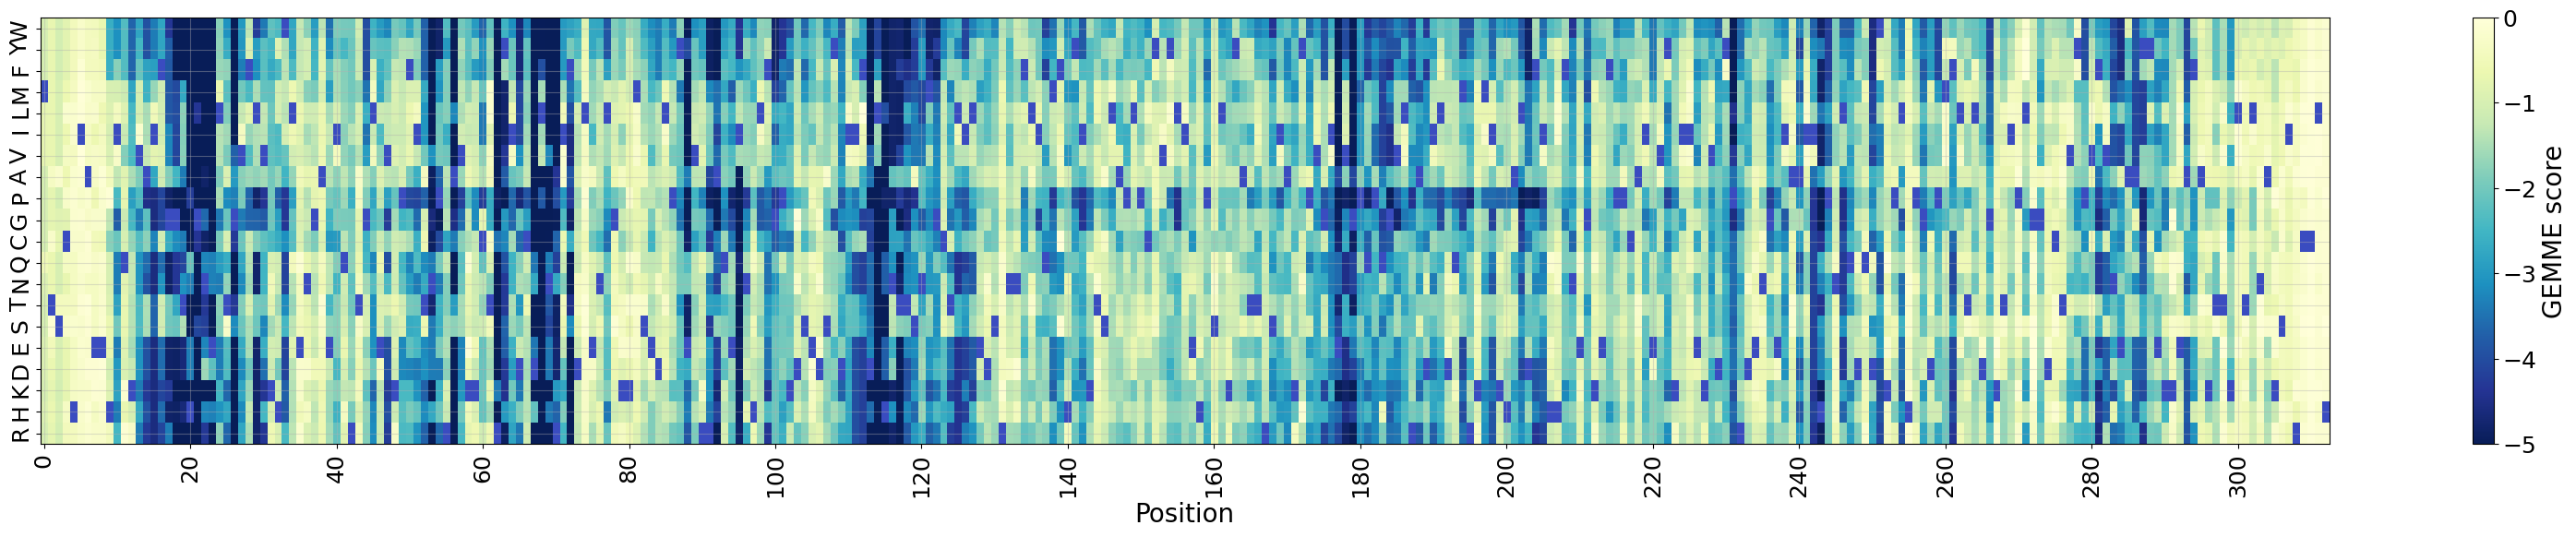

In [291]:
heatmap_scores_reordered(GEMME_ASPA_scores,'GEMME score',ASPA_WT_sequence,-5,0,'YlGnBu_r',[0,len(ASPA_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
plt.savefig('./Figures//ASPA_heatmap_GEMME.pdf',dpi=300, facecolor='w')

#### Rosetta ddgs

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


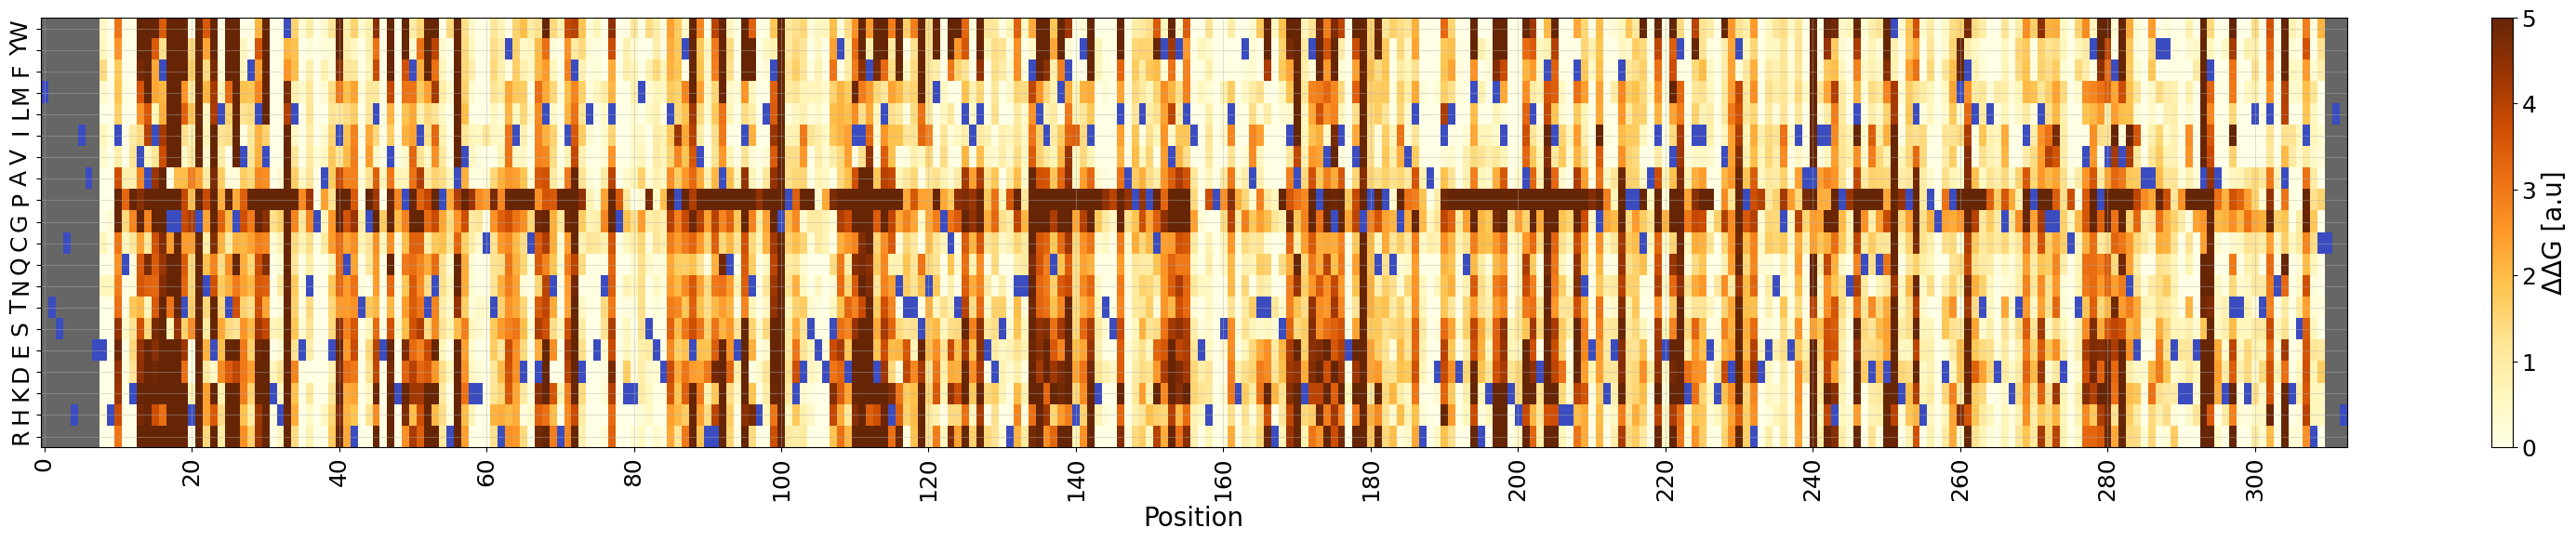

In [292]:
heatmap_scores_reordered(normalized_rosetta_ASPA_monomer_ZN,'\u0394\u0394G [a.u]',ASPA_WT_sequence,0,5,'YlOrBr',[0,len(ASPA_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
plt.savefig('./Figures//ASPA_heatmap_ddg_monomer_ZN.pdf',dpi=300, facecolor='w')

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


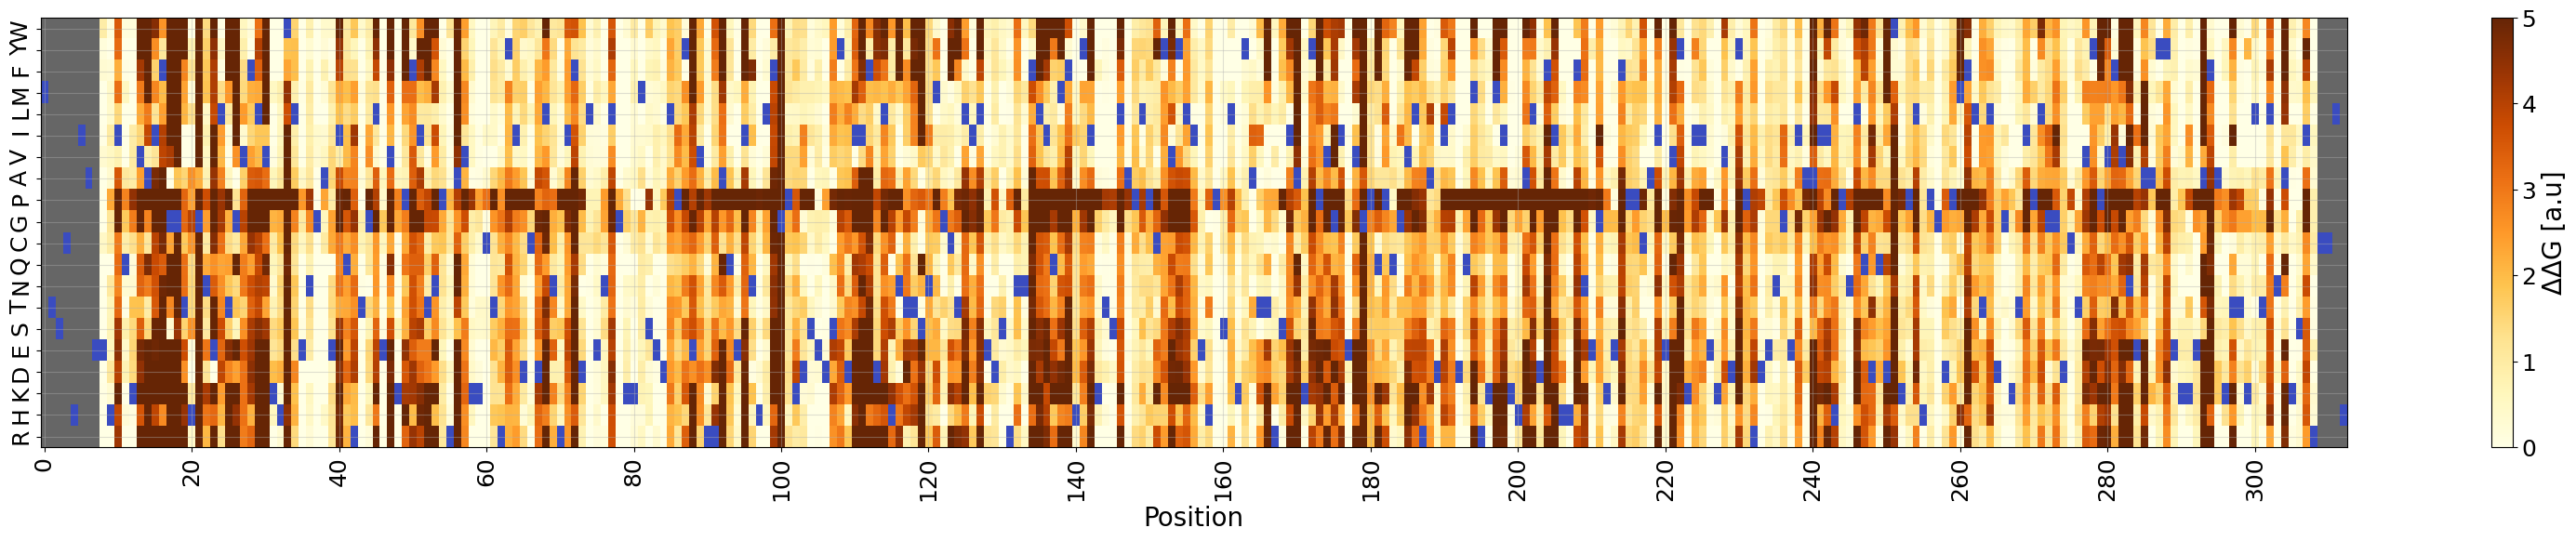

In [293]:
heatmap_scores_reordered(normalized_rosetta_ASPA_dimer,'\u0394\u0394G [a.u]',ASPA_WT_sequence,0,5,'YlOrBr',[0,len(ASPA_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
plt.savefig('./Figures//ASPA_heatmap_ddg_dimer_ZN.pdf',dpi=300, facecolor='w')

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


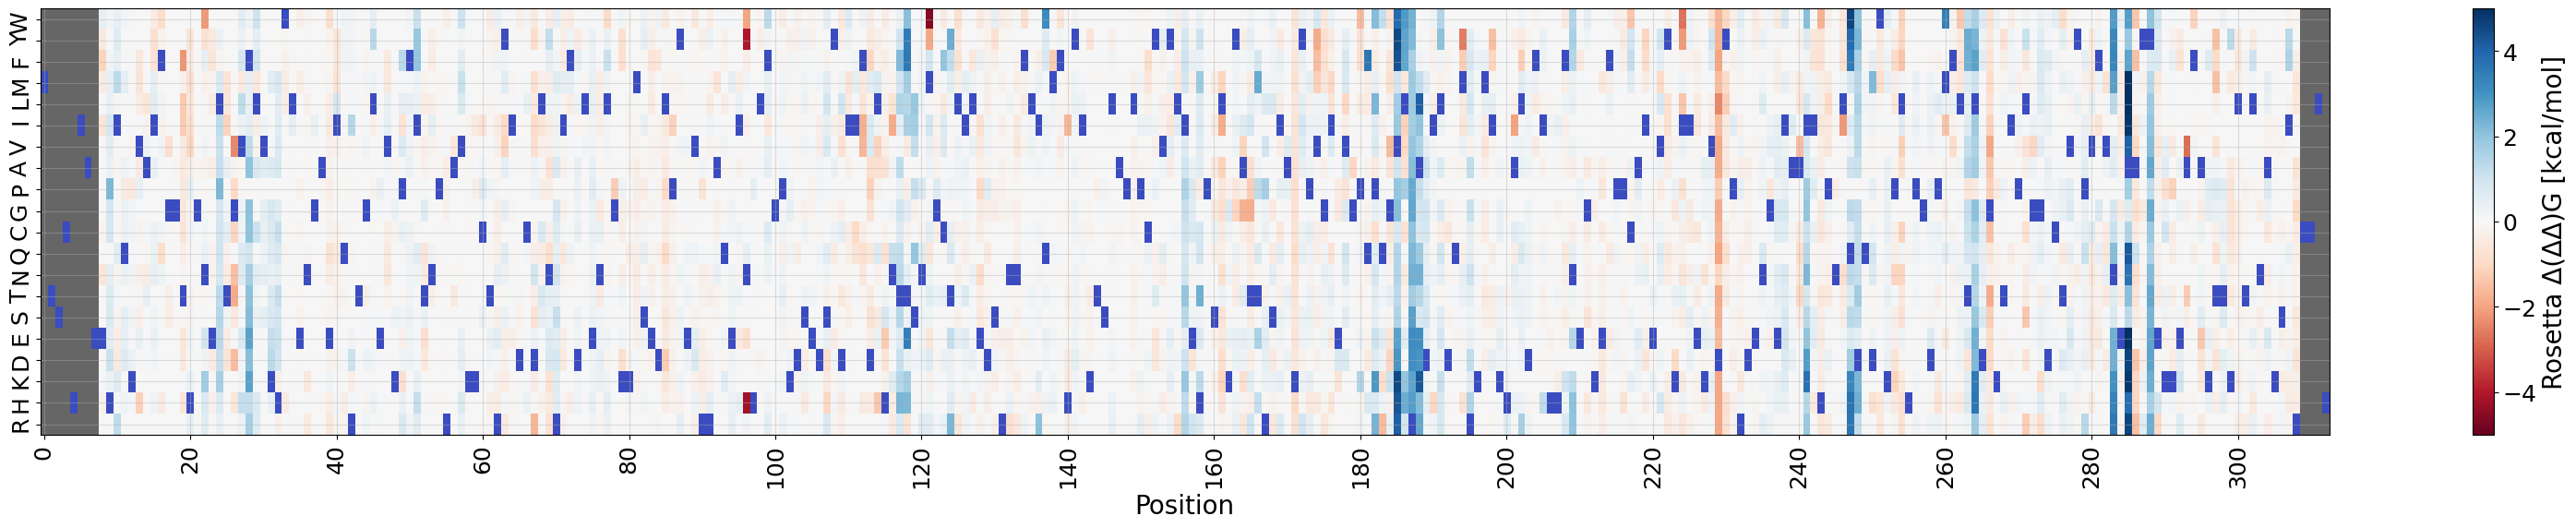

In [294]:
heatmap_scores_reordered(normalized_rosetta_ASPA_dimer-normalized_rosetta_ASPA_monomer_ZN,'Rosetta \u0394(\u0394\u0394)G [kcal/mol]',ASPA_WT_sequence,-5,5,'RdBu',[0,len(ASPA_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
plt.savefig('./Figures//ASPA_heatmap_rosetta_reordered_diff.pdf',dpi=300, facecolor='w')

### residue level

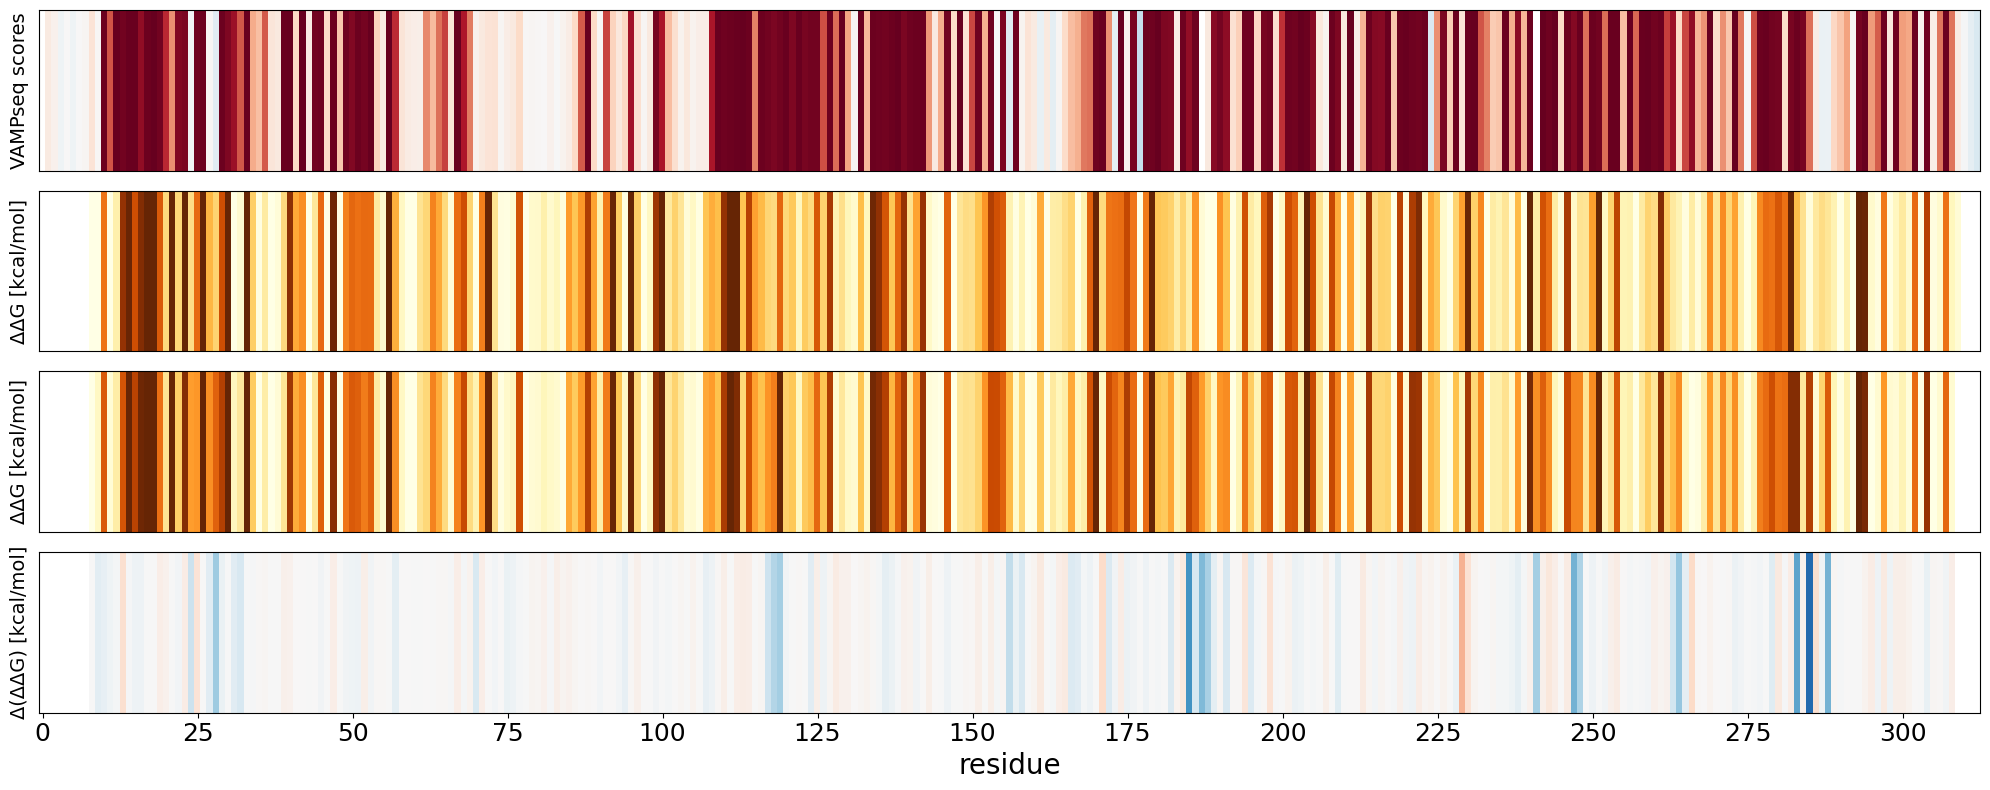

In [295]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax0),(ax1),(ax2),(ax3)) = plt.subplots(4,1,figsize=(20,8))

ax0.imshow(ASPA_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax0.set_yticks([])
ax0.set_ylabel('VAMPseq scores',fontsize=14)
ax0.set_xticks([])

ax1.imshow(normalized_rosetta_ASPA_monomer_ZN_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax1.set_yticks([])
ax1.set_ylabel('\u0394\u0394G [kcal/mol]',fontsize=14)
ax1.set_xticks([])

ax2.imshow(normalized_rosetta_ASPA_dimer_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax2.set_yticks([])
ax2.set_ylabel('\u0394\u0394G [kcal/mol]',fontsize=14)
ax2.set_xticks([])


ax3.imshow(normalized_rosetta_ASPA_dimer_avg-normalized_rosetta_ASPA_monomer_ZN_avg.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=-5,vmax=+5,interpolation='nearest')
ax3.set_yticks([])
ax3.set_ylabel('\u0394(\u0394\u0394G) [kcal/mol]',fontsize=14)
ax3.set_xticks([])

ax3.set_xlabel('residue')
ax3.xaxis.set_ticks(np.arange(0, len(ASPA_WT_sequence), 25))

#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
plt.tight_layout()
plt.savefig('./Figures//ASPA_heatmap_rosetta_diff_res.pdf',dpi=300, facecolor='w')

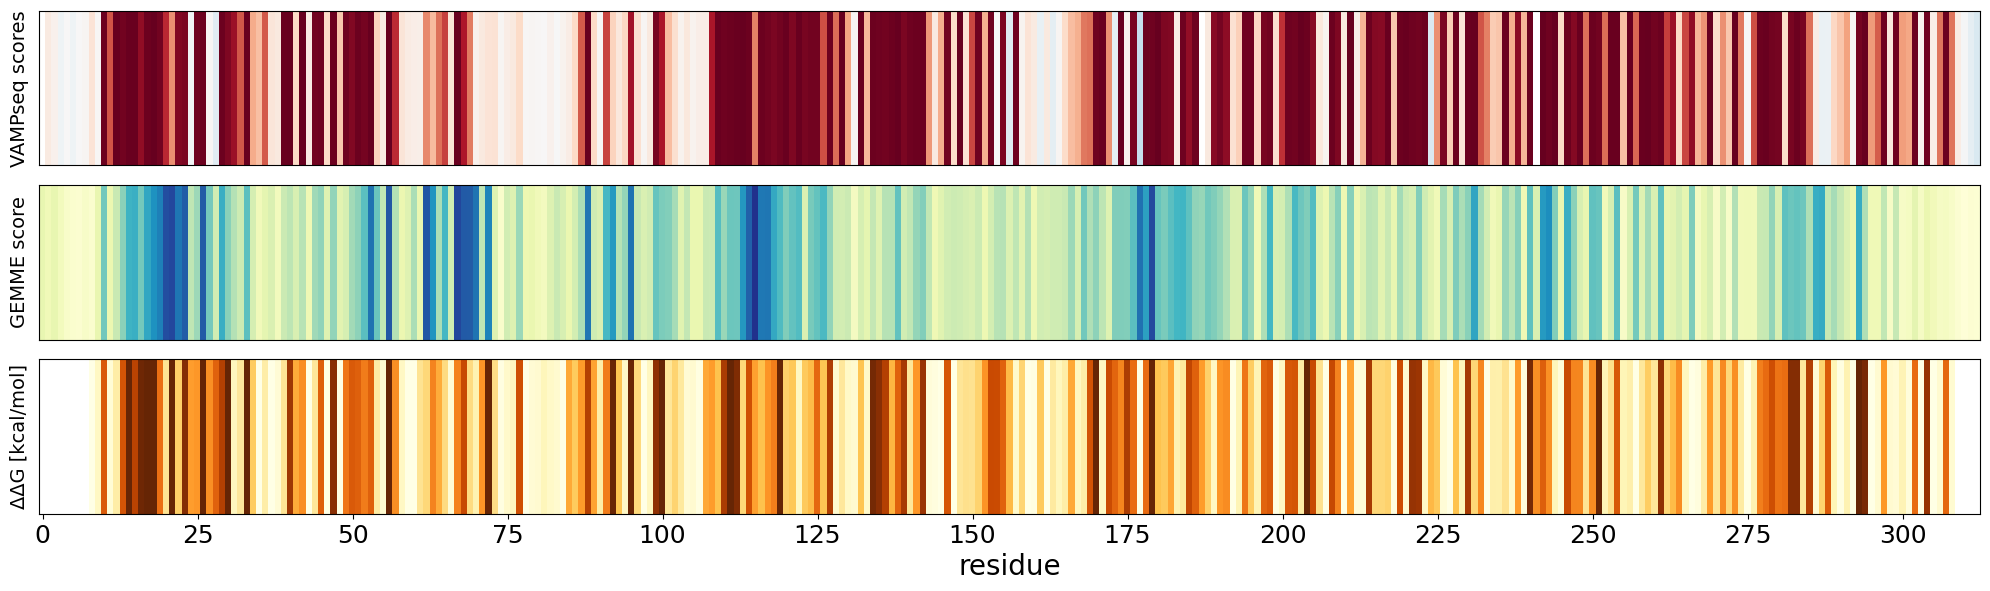

In [296]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax0),(ax1),(ax2)) = plt.subplots(3,1,figsize=(20,6))

ax0.imshow(ASPA_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax0.set_yticks([])
ax0.set_ylabel('VAMPseq scores',fontsize=14)
ax0.set_xticks([])

ax1.imshow(GEMME_ASPA_scores_med.reshape(1,-1),aspect= 'auto',cmap='YlGnBu_r',vmin=-7,vmax=0,interpolation='nearest')
ax1.set_yticks([])
ax1.set_ylabel('GEMME score',fontsize=14)
ax1.set_xticks([])

ax2.imshow(normalized_rosetta_ASPA_dimer_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax2.set_yticks([])
ax2.set_ylabel('\u0394\u0394G [kcal/mol]',fontsize=14)
ax2.set_xticks([])

ax2.set_xlabel('residue')
ax2.xaxis.set_ticks(np.arange(0, len(ASPA_WT_sequence), 25))

#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
plt.tight_layout()
plt.savefig('./Figures//ASPA_heatmap_comparisons.pdf',dpi=300, facecolor='w')

### Hist vamp-seq scores

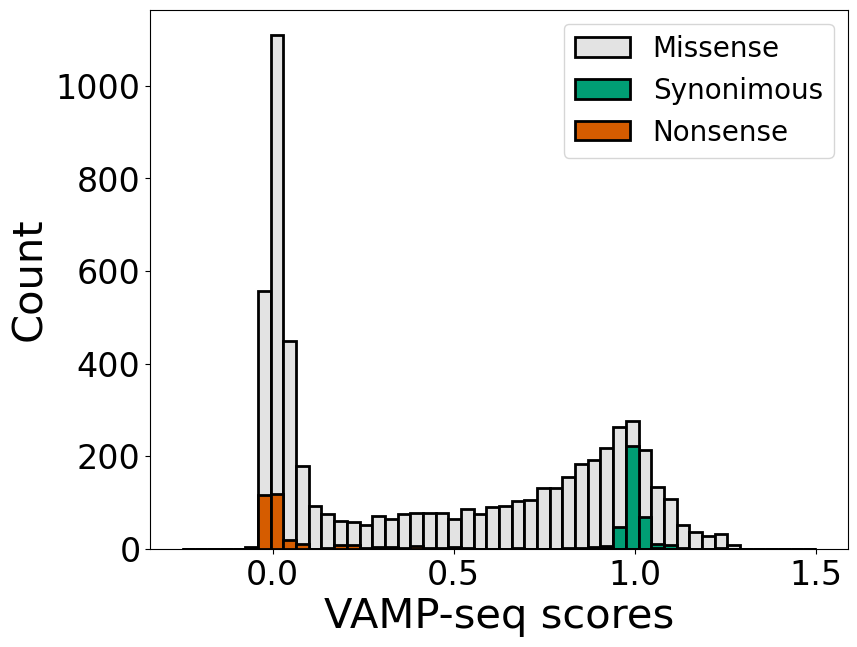

In [62]:
fig, ax = plt.subplots(figsize=(9,7))

ax.hist(ASPA_scores.flatten(),bins=50, range=(-0.25,1.5),facecolor='#e3e3e3',edgecolor='k',lw=2,label='Missense')
ax.hist(ASPA_syn_scores.flatten(),bins=50,range=(-0.25,1.5),facecolor='#009E74',edgecolor='k',lw=2,label='Synonimous')
ax.hist(ASPA_stop_scores.flatten(),bins=50,range=(-0.25,1.5),facecolor='#d55c00',edgecolor='k',lw=2,label='Nonsense')

ax.tick_params(axis='both',labelsize=24)
ax.legend(fontsize=20)
ax.set_xlabel('VAMP-seq scores',fontsize=30)
ax.set_ylabel('Count',fontsize=30)

plt.savefig('./Figures//hist_ASPA_score_syn_ter.pdf',tight_layout=True)

### Low Throughput exp comparison

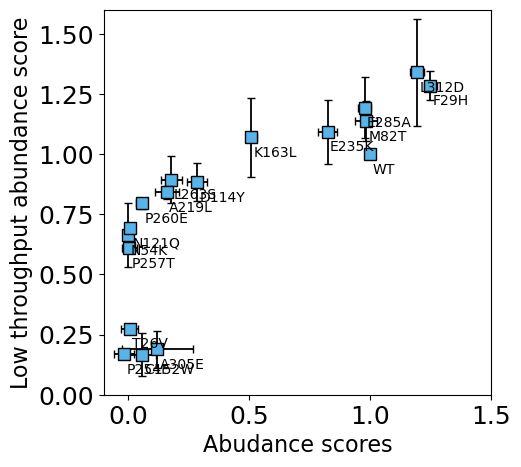

In [319]:
fig, ax = plt.subplots(figsize=(5,5))

ax.errorbar(df_low_t['abundance_score'],df_low_t['fluorescence_low_score'],yerr=df_low_t['fluorescence_low_std'],xerr=df_low_t['abundance_std'],fmt='s',
            elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

label_single=df_low_t['variant'].to_list()
for i, label in enumerate(label_single):
    ax.annotate(label, (df_low_t['abundance_score'][i]+0.01,df_low_t['fluorescence_low_score'][i]-0.08))

    
    
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# p0 = [max(ASPA_degron_single_tiles['Mean'].to_numpy().flatten()), np.median(ASPA_degron_single_tiles['vamp'].to_numpy().flatten()),0,min(ASPA_degron_single_tiles['Mean'].to_numpy().flatten())] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, ASPA_degron_single_tiles['vamp'].to_numpy().flatten(), ASPA_degron_single_tiles['Mean'].to_numpy().flatten(),p0, method='dogbox')
    
    
    
ax.set_xlim(-0.1,1.5)
ax.set_ylim(-0,1.6)

ax.set_xlabel('Abudance scores',fontsize=16)
ax.set_ylabel('Low throughput abundance score',fontsize=16)

plt.savefig('./Figures//ASPA_tile_single_replicas.pdf')

### Correlations with experiments:


spearman's r: 0.47782597420230816
boostraping confidence interval: ConfidenceInterval(low=0.4574671330318054, high=0.49783861299993626)


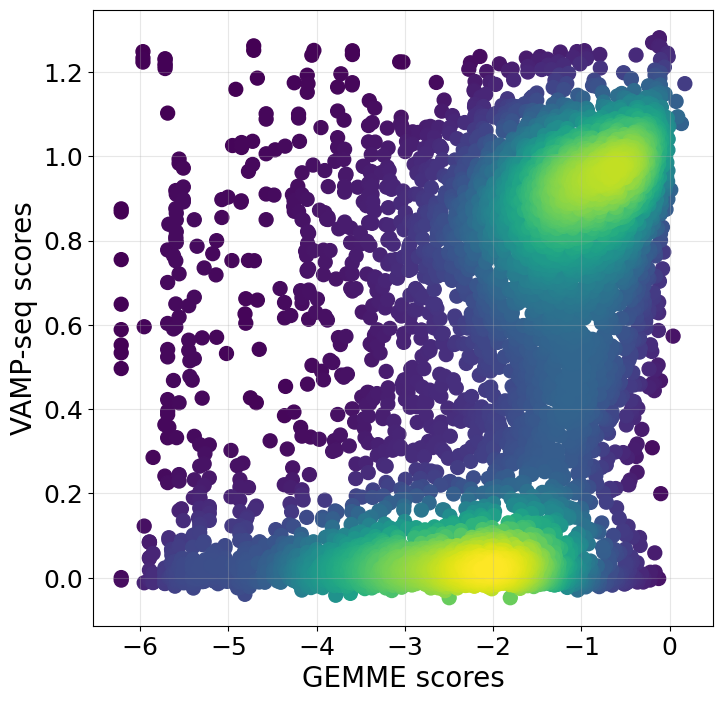

In [299]:
correlation_plot(GEMME_ASPA_scores.flatten(),ASPA_scores.flatten(),'GEMME scores', 'VAMP-seq scores')

plt.savefig('./Figures//ASPAG_correlation_GEMME_full_VAMPseq.pdf',dpi=300, facecolor='w')

spearman's r: 0.49475338914973604
boostraping confidence interval: ConfidenceInterval(low=0.4040242481095858, high=0.5757725294339047)


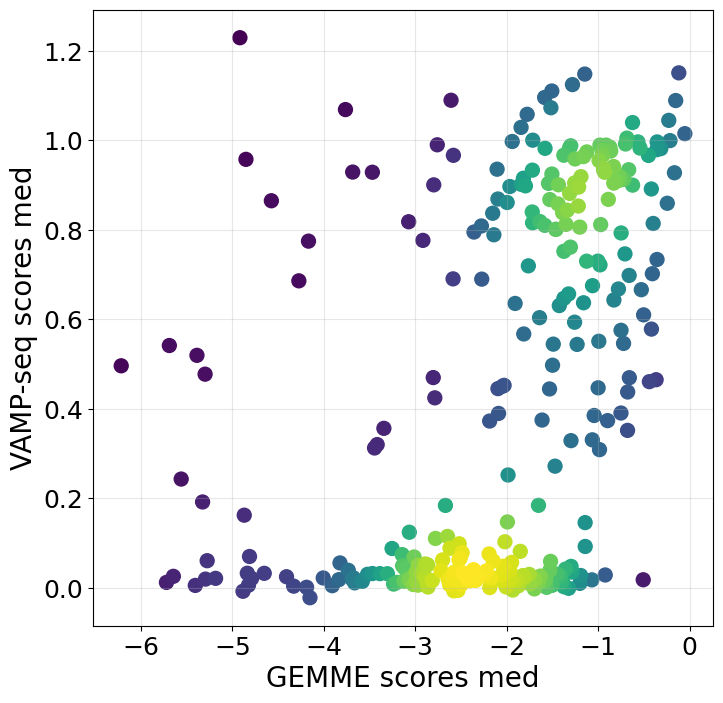

In [300]:
correlation_plot(GEMME_ASPA_scores_med.flatten(),ASPA_scores_med.flatten(),'GEMME scores med', 'VAMP-seq scores med')

plt.savefig('./Figures//ASPAG_correlation_GEMME_full_VAMPseq_med.pdf',dpi=300, facecolor='w')

spearman's r: -0.4768221868516927
boostraping confidence interval: ConfidenceInterval(low=-0.49595656072502653, high=-0.45676853727551553)


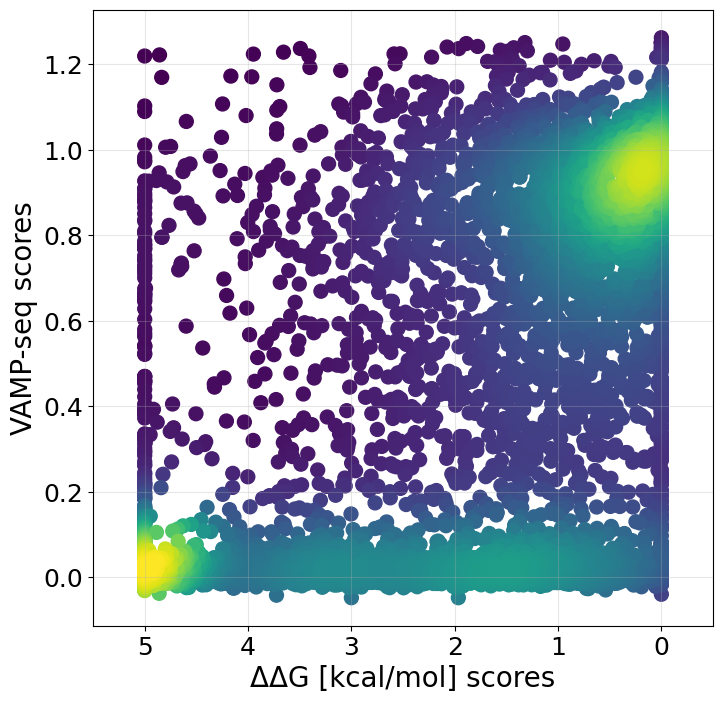

In [320]:
correlation_plot(normalized_rosetta_ASPA_monomer_ZN.flatten(),ASPA_scores.flatten(),'\u0394\u0394G [kcal/mol] scores', 'VAMP-seq scores')
plt.xlim(5.5,-0.5)
plt.savefig('./Figures/ASPA_correlation_rosetta_full_VAMPseq_monomer.pdf',dpi=300, facecolor='w')

spearman's r: -0.4677260552300216
boostraping confidence interval: ConfidenceInterval(low=-0.48749254860417995, high=-0.44699213858014264)


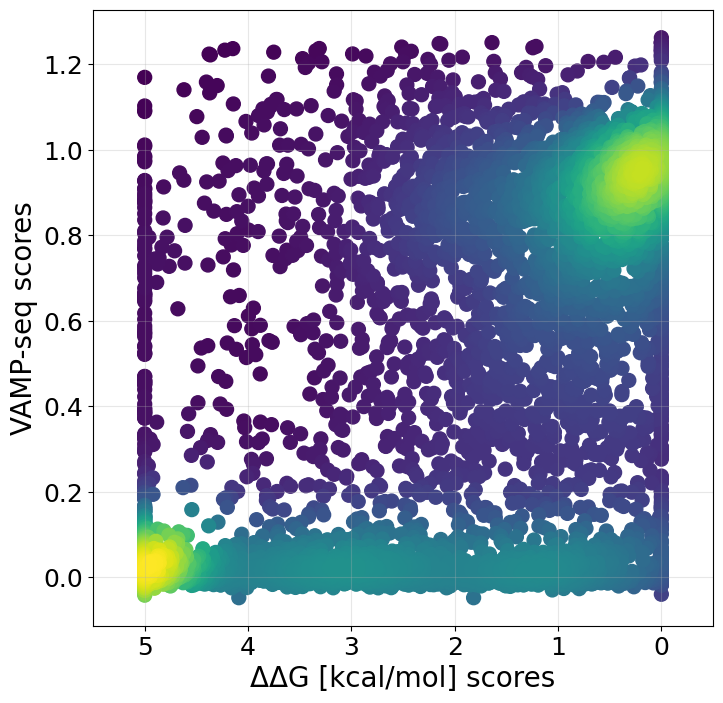

In [321]:
correlation_plot(normalized_rosetta_ASPA_dimer.flatten(),ASPA_scores.flatten(),'\u0394\u0394G [kcal/mol] scores', 'VAMP-seq scores')
plt.xlim(5.5,-0.5)
plt.savefig('./Figures//ASPA_correlation_rosetta_full_VAMPseq_dimer.pdf',dpi=300, facecolor='w')

spearman's r: -0.5499371623475119
boostraping confidence interval: ConfidenceInterval(low=-0.62031967208123, high=-0.4678403449812075)


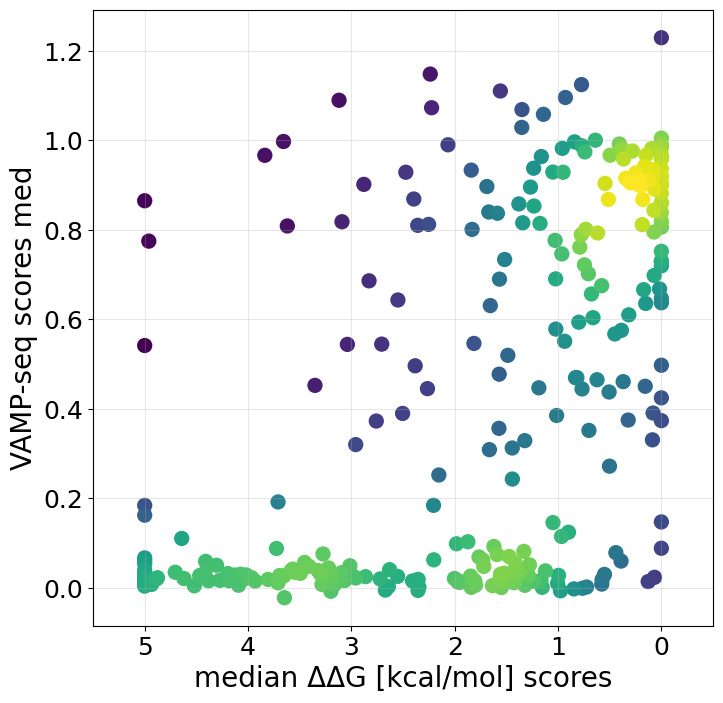

In [322]:
correlation_plot(normalized_rosetta_ASPA_monomer_ZN_avg.flatten(),ASPA_scores_med.flatten(),'median \u0394\u0394G [kcal/mol] scores', 'VAMP-seq scores med')
plt.xlim(5.5,-0.5)
plt.savefig('./Figures//ASPA_correlation_rosetta_full_VAMPseq_med.pdf',dpi=300, facecolor='w')

spearman's r: -0.5241712465262567
boostraping confidence interval: ConfidenceInterval(low=-0.5997331764052249, high=-0.43240085232178327)


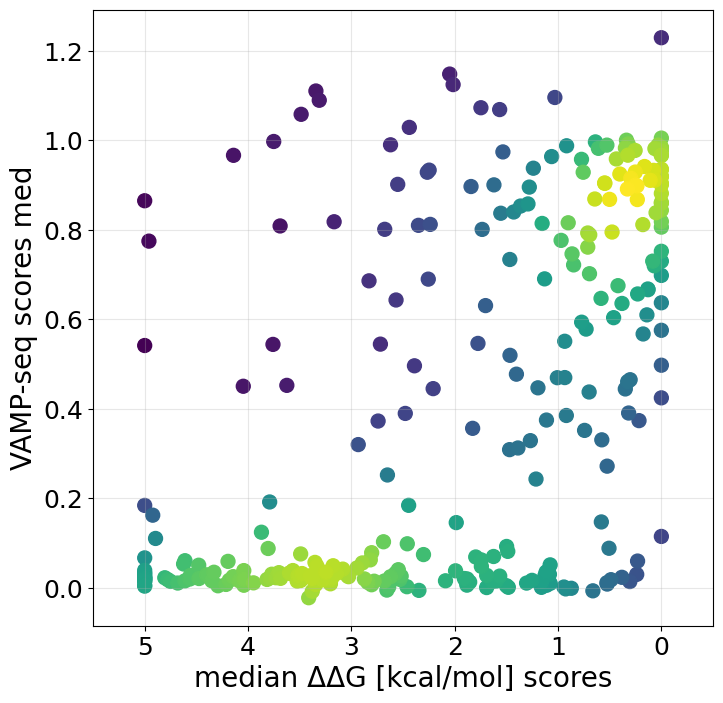

In [323]:
correlation_plot(normalized_rosetta_ASPA_dimer_avg.flatten(),ASPA_scores_med.flatten(),'median \u0394\u0394G [kcal/mol] scores', 'VAMP-seq scores med')
plt.xlim(5.5,-0.5)
plt.savefig('./Figures//ASPA_correlation_rosetta_full_VAMPseq_med_dimer.pdf',dpi=300, facecolor='w')

### Degron analysis

#### experimental

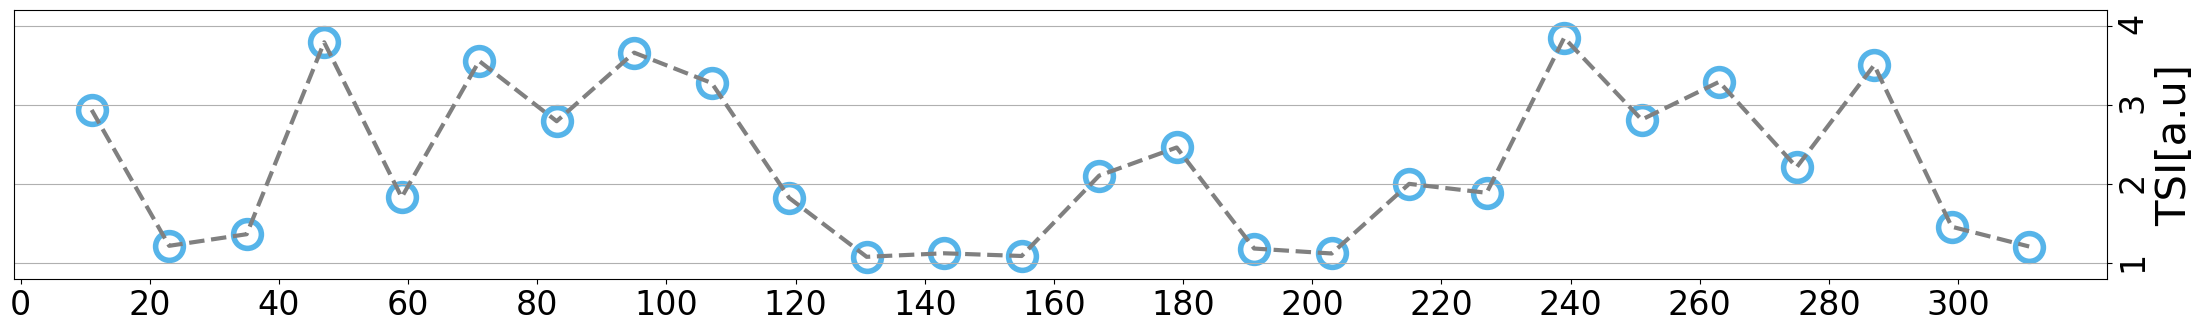

In [305]:
fig,ax =plt.subplots(1,1,figsize=(27,3.5))
idx_deg=np.arange(11,313,12)
ax.plot(idx_deg,ASPA_degron_tiles,ls='--',color='grey',lw=3)

ax.scatter(idx_deg,ASPA_degron_tiles,marker='o',c='white',lw=2,s=400,facecolor='white',edgecolor='#56b4e9', linewidth=4)

ax.set_ylabel('TSI[a.u]',fontsize=30)
ax.set_xticks(np.arange(5, len(ASPA_WT_sequence), 12))
ax.set_ylim(0.8,4.2)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.set_xticks(np.arange(0, len(ASPA_WT_sequence),20))
ax.tick_params(axis='x',rotation=90)
ax.set_xticklabels(np.arange(0, len(ASPA_WT_sequence), 20),fontsize=24,rotation=0)
ax.set_xlim(-1,len(ASPA_WT_sequence)+10)

ax.set_yticks(np.arange(1, 4.5, 1))
ax.tick_params(axis='y',rotation=90)
ax.set_yticklabels(np.arange(1, 5, 1),fontsize=24)
ax.grid(axis='y',which='major')

plt.savefig('./Figures//ASPA_degron_exp_unique.pdf')

#### QCD prediction

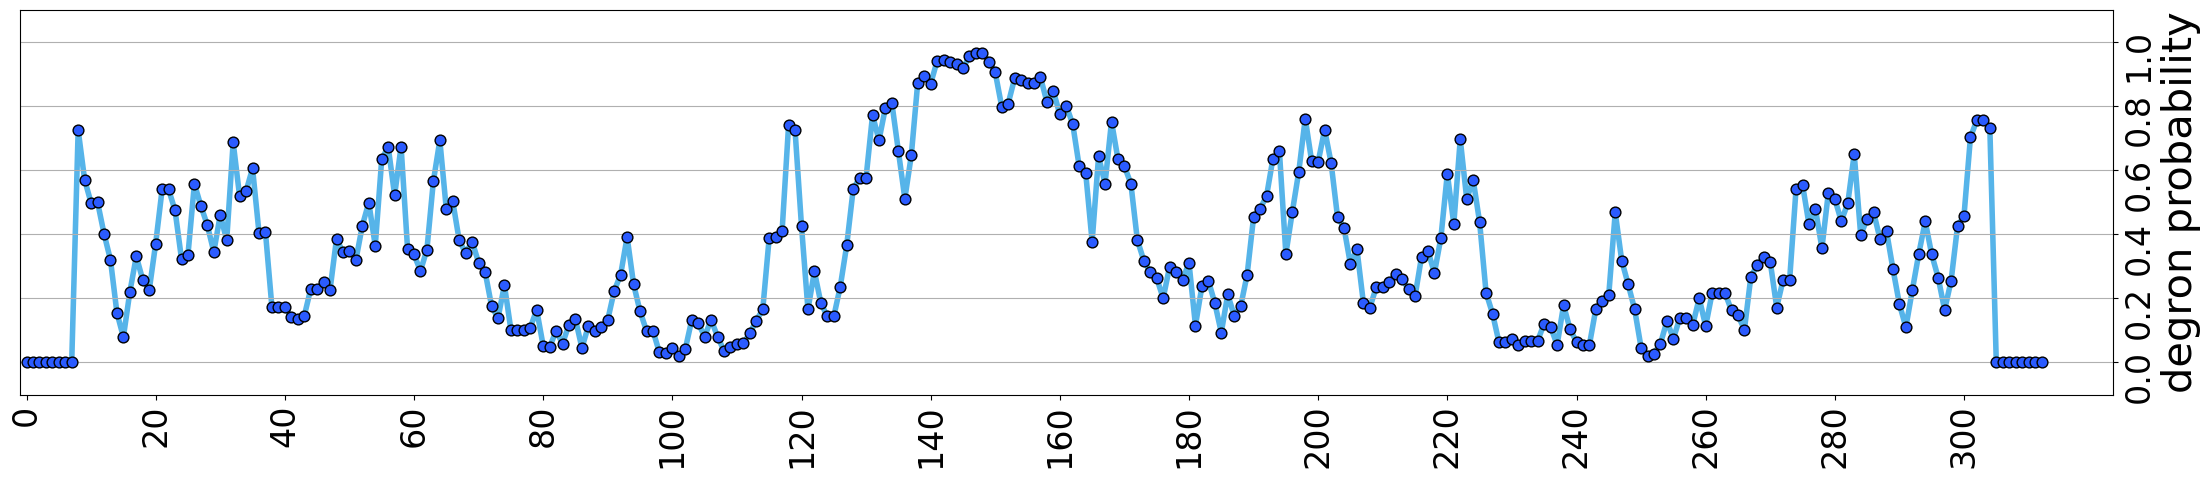

In [306]:
fig,ax =plt.subplots(1,1,figsize=(27,5))
ax.plot(np.arange(0,len(ASPA_WT_sequence),1),ASPA_QCDpred_residue.flatten(),ls='-',color='#56B4E9',lw=4,zorder=1)
ax.scatter(np.arange(0,len(ASPA_WT_sequence),1),ASPA_QCDpred_residue.flatten(),marker='o',lw=1,s=60,facecolor='#2B5BFF',edgecolor='k',zorder=10)
ax.set_ylabel('degron probability',fontsize=30)
ax.set_xticks(np.arange(5, len(ASPA_WT_sequence), 12))

ax.set_xlim(-1,313+10)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


ax.set_xticks(np.arange(0, len(ASPA_WT_sequence),20))
ax.tick_params(axis='x',rotation=90)
ax.set_xticklabels(np.arange(0, len(ASPA_WT_sequence), 20),fontsize=24)

#ax.set_yticks(np.arange(0,1,0.2))
ax.tick_params(axis='y',rotation=90)
ax.set_yticklabels([-0.2,0.,.2,.4,.6,.8,1.],fontsize=24)
ax.set_ylim(-0.1,1.1)
ax.grid(axis='y',which='major')

plt.savefig('./Figures//ASPA_degron_pred_unique.pdf')

#### WCN tile

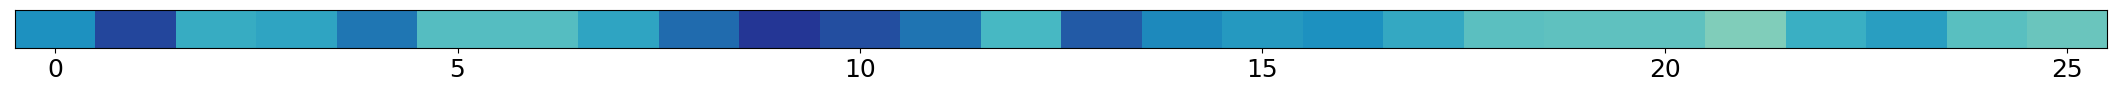

In [307]:
fig, (ax1) = plt.subplots(1,1,figsize=(27,0.5))

ax1.imshow(np.array(ASPA_wcn_tile).reshape(1,-1),aspect= 'auto',cmap='YlGnBu',vmin=0,vmax=21,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(ASPA_wcn_tile)+.5-1)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/PARKIN_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('./Figures//ASPA_heamap_WCN_tile.pdf',dpi=300, facecolor='w')

### WCN vs abundance

SpearmanrResult(correlation=nan, pvalue=nan)


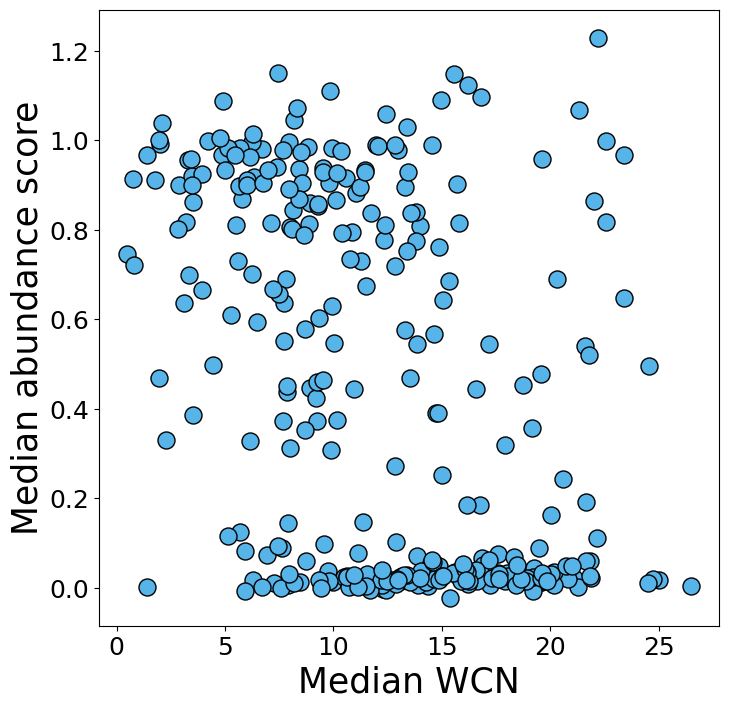

In [310]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.scatter(ASPA_wcn.flatten(),ASPA_scores_med.flatten(),s=150,edgecolor='k',c='#56b4e9')

ax.set_xlabel('Median WCN',fontsize=25)
ax.set_ylabel('Median abundance score',fontsize=25)


print(sp.stats.spearmanr(ASPA_wcn.flatten(),ASPA_scores_med.flatten()))

plt.savefig('./Figures//ASPA_abundance_med_wcn_medians_tile.pdf')

## Clinical variant analysis

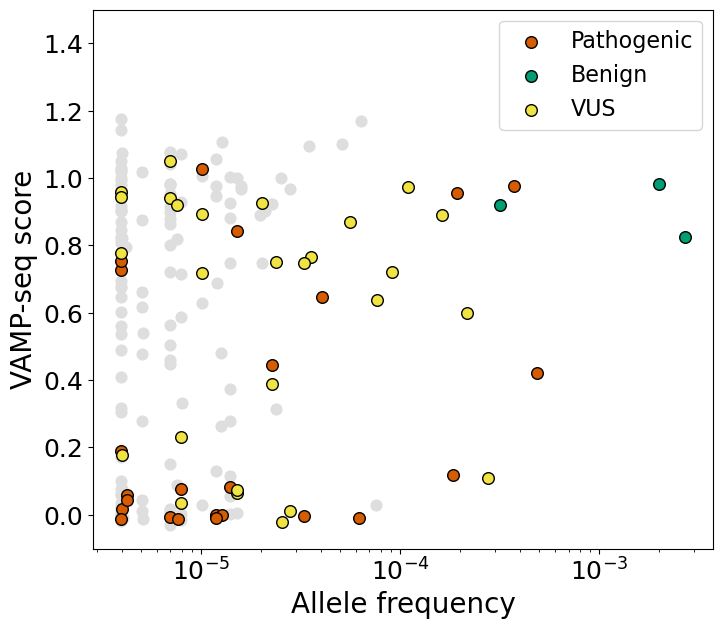

In [311]:
fig,ax=plt.subplots(1,1,figsize=(8,7))

ax.scatter(gnomad_ASPA_freq_db_matrix,ASPA_scores,c='#DEDEDE',s=60)

idx = np.isfinite(df_disease[df_disease['disease']=='pathogenic']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease[df_disease['disease']=='pathogenic']['mave'].to_numpy() )
ax.scatter(df_disease['freq_gnomad'][df_disease['disease']=='pathogenic'].to_numpy()[idx],df_disease['mave'][df_disease['disease']=='pathogenic'].to_numpy()[idx],c='#d55c00',s=70,edgecolors='k',label='Pathogenic')

idx = np.isfinite(df_disease[df_disease['disease']=='benign']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease[df_disease['disease']=='benign']['mave'].to_numpy() )
ax.scatter(df_disease[df_disease['disease']=='benign']['freq_gnomad'].to_numpy()[idx],df_disease[df_disease['disease']=='benign']['mave'].to_numpy()[idx],c='#009e74',s=70,edgecolors='k',label='Benign')

idx = np.isfinite(df_disease[df_disease['disease']=='VUS']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease[df_disease['disease']=='VUS']['mave'].to_numpy() )
ax.scatter(df_disease[df_disease['disease']=='VUS']['freq_gnomad'].to_numpy()[idx],df_disease[df_disease['disease']=='VUS']['mave'].to_numpy()[idx],c='#f0e442',s=70,edgecolors='k',label='VUS')

ax.set_xscale('log')
ax.set_xlabel('Allele frequency')
ax.set_ylabel('VAMP-seq score')
ax.set_ylim(-0.1,1.5)
ax.legend(fontsize=16)
plt.savefig('./Figures//ASPA_gnomad_valid_frequency_variants.pdf')

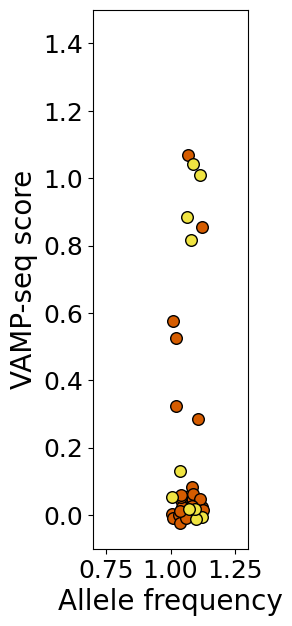

In [312]:
fig,ax=plt.subplots(1,1,figsize=(2,7))
temp=df_disease
temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='pathogenic':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
            
ax.scatter([1+random()/8 for i in range(0,len(temp_array))],temp_array,c='#d55c00',s=70,edgecolors='k')

temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='benign':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])

ax.scatter([1+random()/8 for i in range(0,len(temp_array))],temp_array,c='#009e74',s=70,edgecolor='k')
            
temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='VUS':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
            

ax.scatter([1+random()/8 for i in range(0,len(temp_array))],temp_array,c='#f0e442',s=70,edgecolor='k')


ax.set_xlabel('Allele frequency')
ax.set_ylabel('VAMP-seq score')
ax.set_ylim(-0.1,1.5)
ax.set_xlim(0.7,1.3)
plt.savefig('./Figures//ASPA_gnomad_null_frequency_variants.pdf')

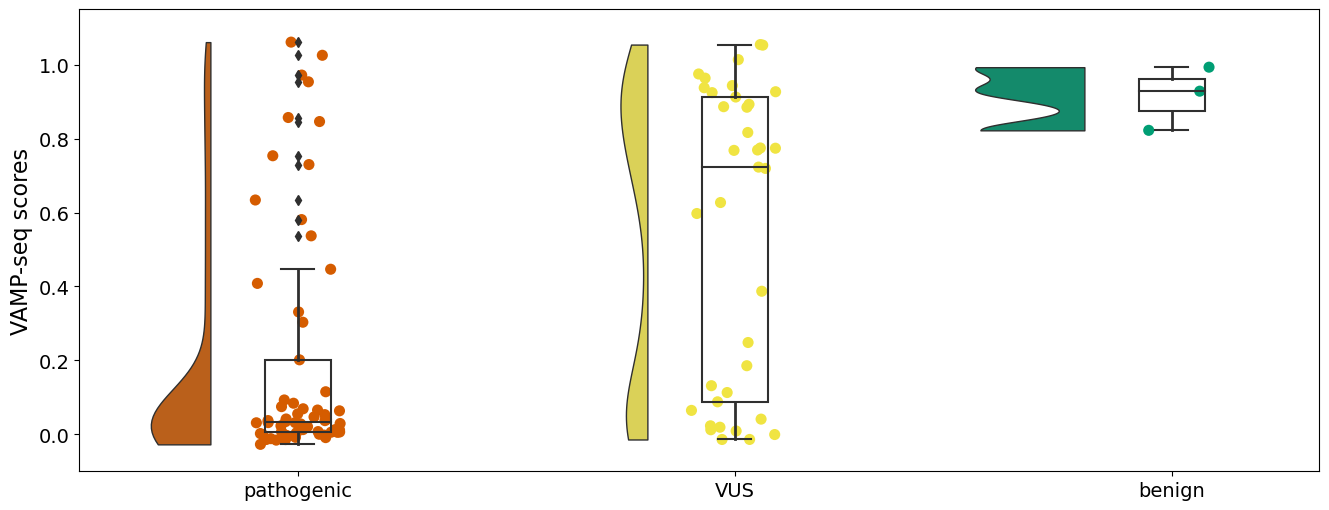

In [117]:
#same thing with a single command: now x **must** be the categorical value
dx = "disease"; dy = "mave"; ort = "v"; pal = "Set2"; sigma = .3
f, ax = plt.subplots(figsize=(16., 6))

ax1=pt.RainCloud(x = dx, y = dy, data = df_disease, palette = ['#d55c00','#f0e442','#009e74'],
      bw = sigma,width_viol = .5, ax = ax, orient = ort,point_size=8, point_color='black')
ax1.set_ylabel('VAMP-seq scores')
ax1.set_xlabel('')
#ax1.plot([-1,3],[PARKIN_syn_scores_med-PARKIN_syn_scores_stdev,PARKIN_syn_scores_med-PARKIN_syn_scores_stdev],c='gray',ls='--',zorder=-1,label='thresholds')
ax.set_ylim(-0.1,1.15)
#ax1.legend()

plt.savefig('./Figures//ASPA_pathogenic_benign_raincloud.pdf',tight_layout=True)

### GEMME vs abudance - clinvar


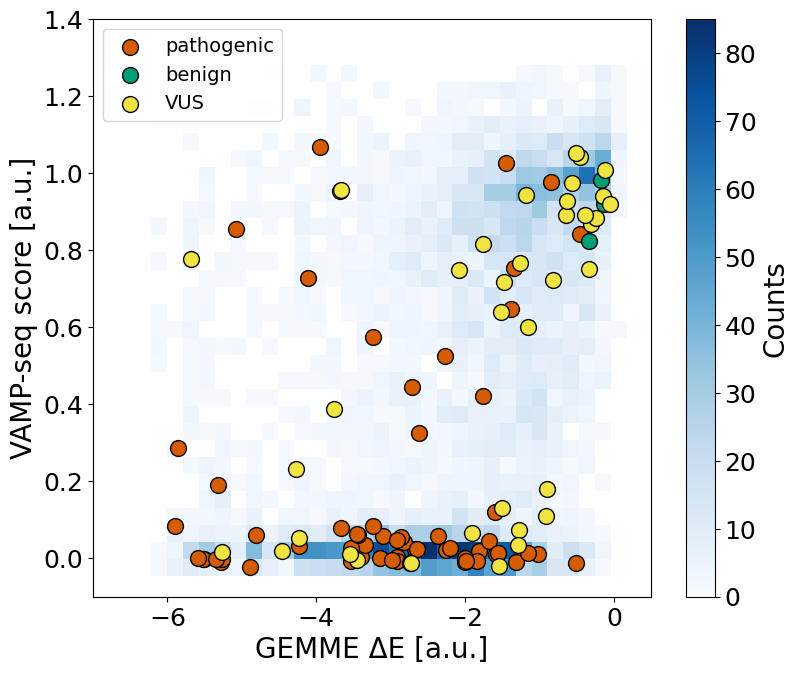

In [313]:
fig,ax=plt.subplots(1,1,figsize=(9,7.5))

y=[]; x=[]

y_size=[1.4,-0.1]
x_size=[-7,0.5]

# Create the vectors with the common dataset between the two experiment
# It remove a variant data if one of the two MAVE array contain a NA as score for that mutation.
for i in range(GEMME_ASPA_scores.shape[0]):
    for j in range(GEMME_ASPA_scores.shape[1]):
        if np.isnan(GEMME_ASPA_scores[i,j]) or np.isnan(ASPA_scores[i,j]):
            pass
        else:
            x.append(float(GEMME_ASPA_scores[i,j]))
            y.append(float(ASPA_scores[i,j]))

# Common variant assays
y=np.array(y)
x=np.array(x)

#Plot the 2d histogram
ax.set_ylabel("VAMP-seq score [a.u.]")
ax.set_xlabel("GEMME \u0394E [a.u.]")
mappable = ax.hist2d(x,y,bins=[30,30],cmap =newcmp2)# norm=mpl.colors.LogNorm()
cbar = fig.colorbar(mappable[3],label="Counts")

#plt.legend(loc='upper left',fontsize=12)
ax.set_xlim(x_size[0],x_size[1])
ax.set_ylim(y_size[1],y_size[0])

ax.scatter(df_disease[df_disease['disease']=='pathogenic']['gemme'].to_numpy(),df_disease[df_disease['disease']=='pathogenic']['mave'].to_numpy(),c='#d55c00',s=130,edgecolors='k',label='pathogenic')
ax.scatter(df_disease[df_disease['disease']=='benign']['gemme'].to_numpy(),df_disease[df_disease['disease']=='benign']['mave'].to_numpy(),c='#009e74',s=130,edgecolors='k',label='benign')
ax.scatter(df_disease[df_disease['disease']=='VUS']['gemme'].to_numpy(),df_disease[df_disease['disease']=='VUS']['mave'].to_numpy(),c='#f0e442',s=130,edgecolors='k',label='VUS')



#ax.scatter(df_disease_select[df_disease['mutation']=='G120D']['gemme'].to_numpy(),df_disease_select[df_disease['mutation']=='G120D']['ddg_soluble'].to_numpy(),c='#d55c00',s=130,edgecolors='k',label='G120D/L185P')
#ax.scatter(df_disease_select[df_disease['mutation']=='L185P']['gemme'].to_numpy(),df_disease_select[df_disease['mutation']=='L185P']['ddg_soluble'].to_numpy(),c='#d55c00',s=130,edgecolors='k')
ax.legend(loc='upper left')
plt.savefig('./Figures//ASPA_2d_vamp_gemme_clinvar.pdf')

### ASPA toxicity 

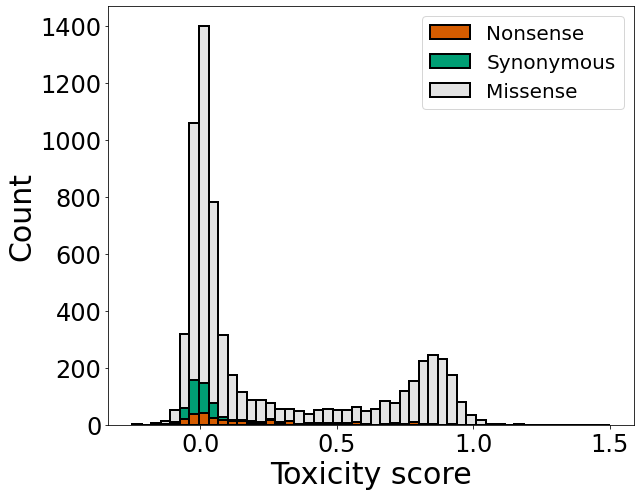

In [290]:
# plot toxicity score histogram
fig, ax = plt.subplots(figsize=(9,7))
ax.hist((ASPA_toxicity_stop_scores,ASPA_toxicity_syn_scores,ASPA_toxicity_score.flatten()),bins=50, range=(-0.25,1.5),color=['#d55c00','#009E74','#e3e3e3'],edgecolor='k',lw=2,label=['Nonsense','Synonymous','Missense'],histtype='barstacked')

ax.tick_params(axis='both',labelsize=24)
ax.legend(fontsize=20)
ax.set_xlabel('Toxicity score',fontsize=30)
ax.set_ylabel('Count',fontsize=30)

plt.tight_layout()
plt.savefig('Figures/hist_ASPA_tox.pdf')

In [71]:
import seaborn as sns
tox_cmap = sns.light_palette("forestgreen", as_cmap=True)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


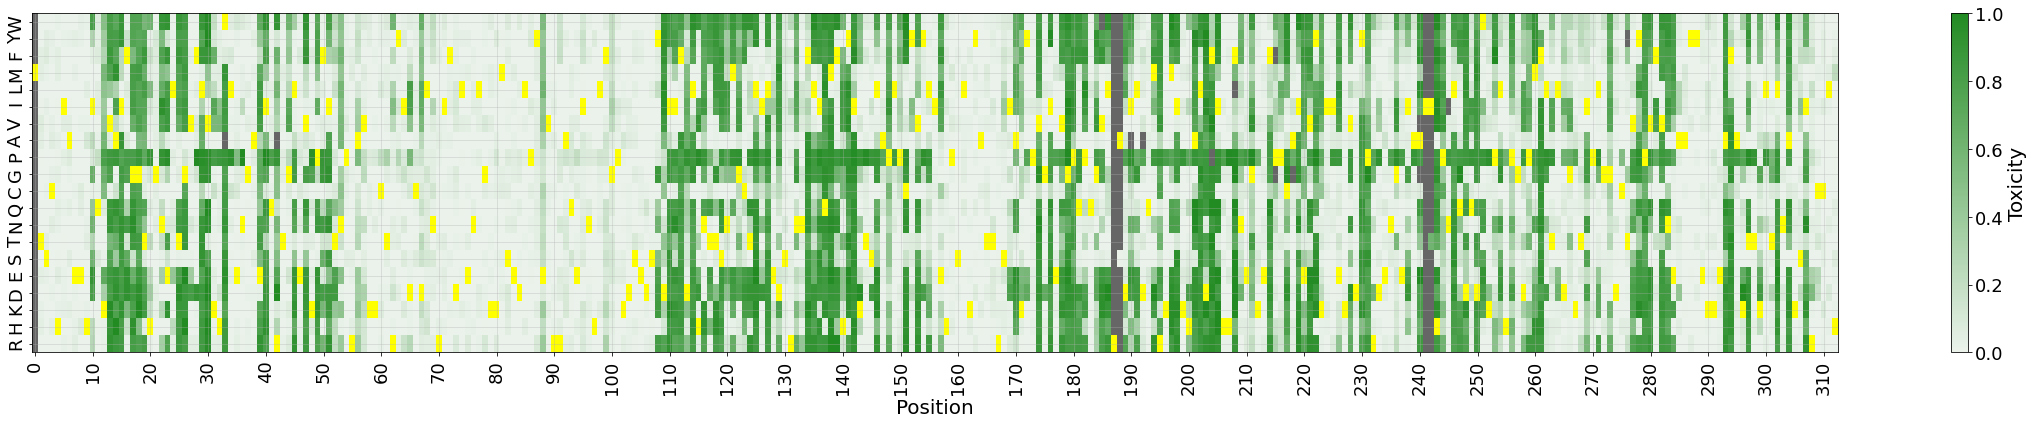

In [138]:
# plot missense variant tox scores as heatmap
heatmap_scores_reordered(ASPA_toxicity_score,'Toxicity',ASPA_WT_sequence,0,1,
                         tox_cmap,[0,len(ASPA_WT_sequence)-1],figs=[32,6])
plt.tight_layout()
plt.savefig('Figures/ASPA_toxicity_heatmap.pdf',dpi=300, facecolor='w')

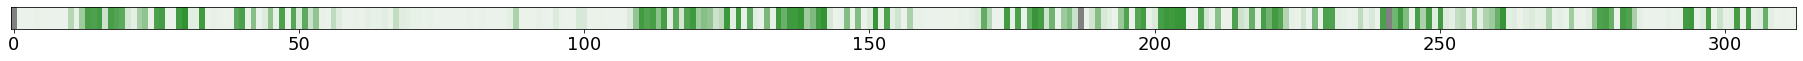

In [139]:
# plot median score per residue position
fig, (ax1) = plt.subplots(1,1,figsize=(32,0.4))
cmap = tox_cmap
cmap.set_bad('gray',1.)
ax1.imshow(ASPA_toxicity_med.reshape(1,-1),cmap=tox_cmap,aspect='auto',vmin=0,vmax=1,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(ASPA_WT_sequence)+.5-1);
plt.savefig('Figures/ASPA_toxicity_median_heatmap.pdf',dpi=300, facecolor='w')

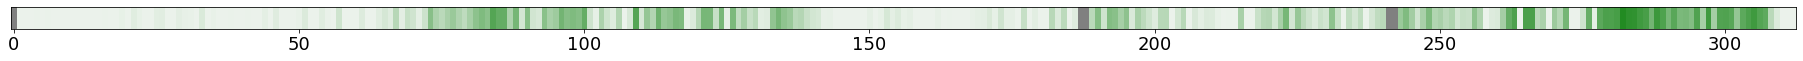

In [189]:
# plot nonsense variant scores
fig, (ax1) = plt.subplots(1,1,figsize=(32,0.4))
cmap = tox_cmap
cmap.set_bad('gray',1.)
ax1.imshow(ASPA_toxicity_stop_scores.reshape(1,-1),cmap=tox_cmap,aspect='auto',vmin=0,vmax=1,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(ASPA_WT_sequence)+.5-1);
plt.savefig('Figures/ASPA_toxicity_nonsense_heatmap.pdf',dpi=300, facecolor='w')

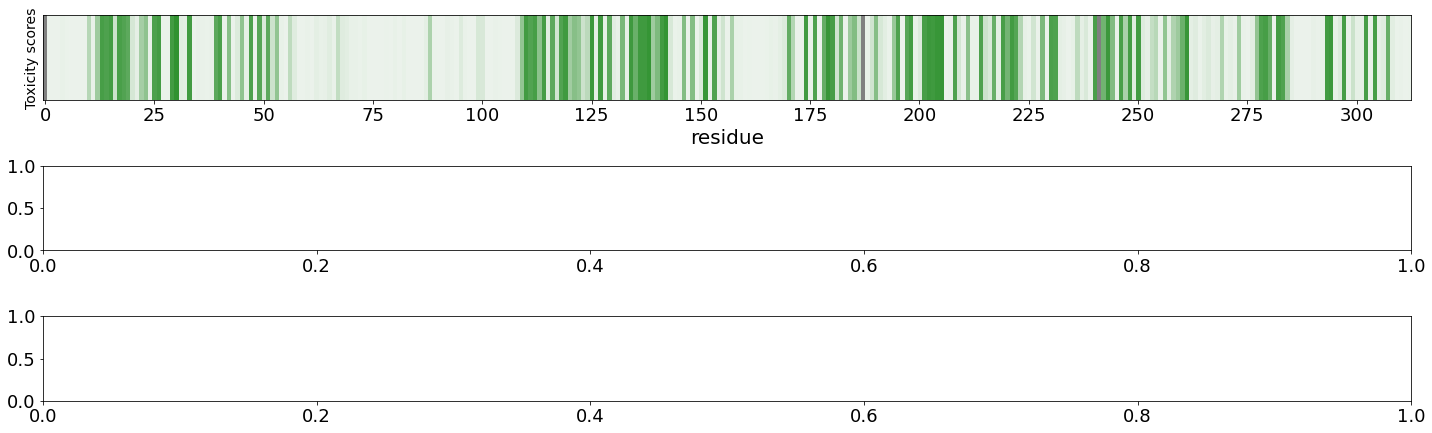

In [192]:
# plot median score per residue position
fig, ((ax0),(ax1),(ax2)) = plt.subplots(3,1,figsize=(20,6))
ax0.imshow(ASPA_toxicity_med.reshape(1,-1),aspect= 'auto',cmap=tox_cmap,vmin=0,vmax=1,interpolation='nearest')
ax0.set_yticks([])
ax0.set_ylabel('Toxicity scores',fontsize=14)
ax0.set_xticks([])
ax0.set_xlabel('residue')
ax0.xaxis.set_ticks(np.arange(0, len(ASPA_WT_sequence), 25))
plt.tight_layout()
plt.savefig('Figures/ASPA_heatmap_comparisons.pdf',dpi=300, facecolor='w')

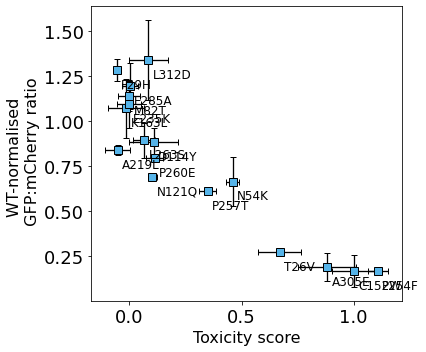

In [203]:
# plot toxicity vs low-throughput fluorescence measurements
scatter('tox_score','fluorescence_low_score','tox_std','fluorescence_low_std',df_low_t_tox,'Toxicity score','WT-normalised \n GFP:mCherry ratio','ASPA_tox_fluorescence.pdf')

### ASPA toxicity vs GEMME and Rosetta and WCN

spearman's r: -0.7713905824025452
boostraping confidence interval: ConfidenceInterval(low=-0.7791567055632503, high=-0.7637594812478314)


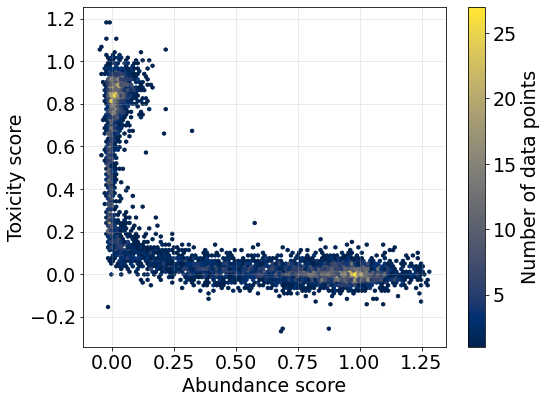

In [84]:
# plot abundance vs tox for all missense variants
hexbin_correlation_plot(ASPA_scores.flatten(),ASPA_toxicity_score.flatten(),x_label='Abundance score',y_label='Toxicity score',cmap="cividis")
plt.tight_layout()
plt.savefig('updated_figures/ASPA_abundance_tox_correlation.pdf',dpi=300, facecolor='w')

spearman's r: 0.5272646570094057
boostraping confidence interval: ConfidenceInterval(low=0.5069448443625195, high=0.5462287699308951)


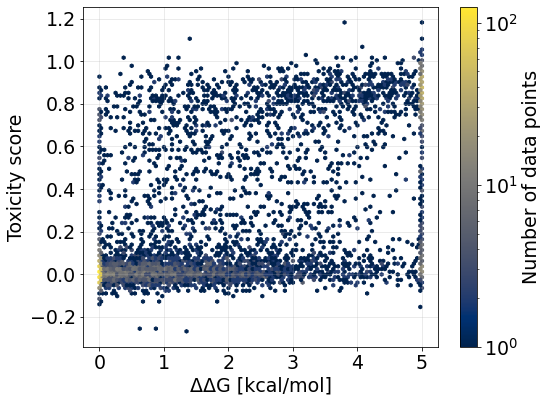

In [85]:
# correlate toxicity with ddG for all missense variants
hexbin_correlation_plot(normalized_rosetta_ASPA_dimer.flatten(),ASPA_toxicity_score.flatten(),x_label='\u0394\u0394G [kcal/mol]',y_label='Toxicity score',bins='log',cmap="cividis")
plt.tight_layout()
plt.savefig('updated_figures/ASPA_ddG_tox_correlation.pdf',dpi=300, facecolor='w')

spearman's r: -0.46665596135493614
boostraping confidence interval: ConfidenceInterval(low=-0.48646845235845443, high=-0.446418830691623)


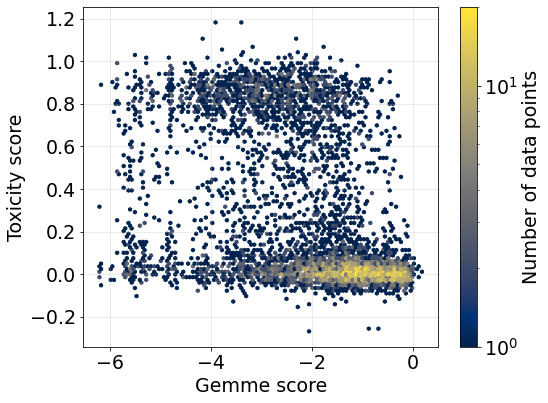

In [86]:
# correlate toxicity with ddE for all missense variants
hexbin_correlation_plot(GEMME_ASPA_scores.flatten(),ASPA_toxicity_score.flatten(),x_label='Gemme score',y_label='Toxicity score',bins='log',cmap="cividis")
plt.tight_layout()
plt.savefig('updated_figures/ASPA_gemme_tox_correlation.pdf',dpi=300, facecolor='w')

spearman's r: 0.337897847035429
boostraping confidence interval: ConfidenceInterval(low=0.31499054505156476, high=0.3602548025153862)


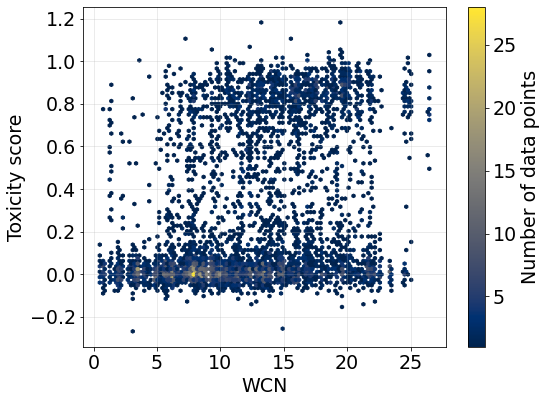

In [87]:
# correlate toxicity with WCN for all missense variants
hexbin_correlation_plot(df_input.wcn_sidechains_AF.values,df_input.tox_score.values,x_label='WCN',y_label='Toxicity score',bins=None,cmap="cividis")
plt.tight_layout()
plt.savefig('updated_figures/ASPA_WCN_toxicity_all_variants.pdf')

spearman's r: 0.4815839448888336
boostraping confidence interval: ConfidenceInterval(low=0.3922820241528392, high=0.5615991669222506)


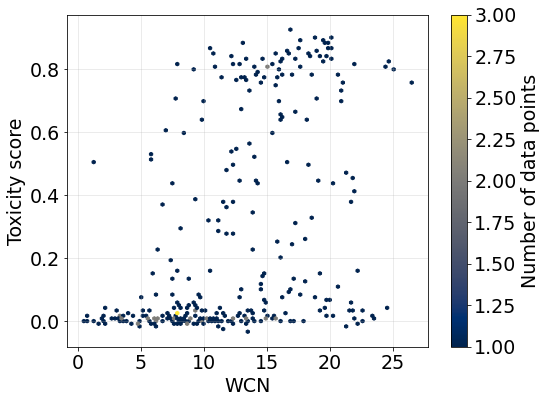

In [88]:
# correlate toxicity with WCN on residue level, tox is median per residue
hexbin_correlation_plot(ASPA_wcn,ASPA_toxicity_med,x_label='WCN',y_label='Toxicity score',bins=None,cmap="cividis")
plt.tight_layout()
plt.savefig('updated_figures/ASPA_WCN_toxicity_median_per_residue.pdf')

### HSP70 expression

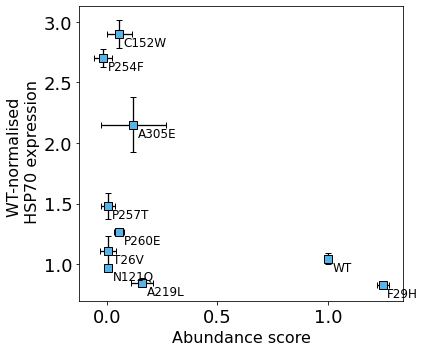

In [304]:
# plot abundance score vs HSP expression
scatter('abundance_score','hsp70_mean','abundance_std','hsp70_std',hsp70_low_t_tox_df,'Abundance score','WT-normalised \n HSP70 expression','hsp70_abundance.pdf')

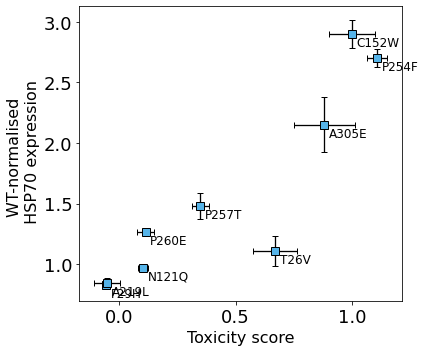

In [305]:
# plot toxicity score vs HSP expression
scatter('tox_score','hsp70_mean','tox_std','hsp70_std',hsp70_low_t_tox_df,'Toxicity score','WT-normalised \n HSP70 expression','hsp70_toxicity.pdf')

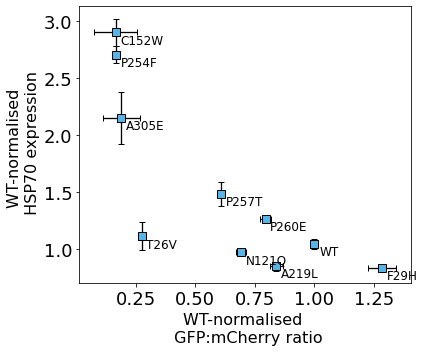

In [306]:
# plot low-throughput fluorescence vs HSP expression
scatter('fluorescence_low_score','hsp70_mean','fluorescence_low_std','hsp70_std',hsp70_low_t_tox_df,'WT-normalised \n GFP:mCherry ratio','WT-normalised \n HSP70 expression','hsp70_fluorescence.pdf')

### GnomAD vs toxicity

In [87]:
import seaborn as sns
from scipy.stats import bootstrap

In [88]:
def bootstrap_mean_median(data_arr, n_samples):

    bootstrap_dist_mean = []
    bootstrap_dist_median = []
    
    for i in range(n_samples):
        
        sample = np.random.choice(data_arr, size=len(data_arr), replace=True)
        
        bootstrap_dist_mean.append(np.mean(sample))
        bootstrap_dist_median.append(np.median(sample))
            
    return bootstrap_dist_mean, bootstrap_dist_median

In [89]:
# remove synonymous variants
variant_arr = df_input.variant.values
aa_var = np.array([aa[-1] for aa in variant_arr])
df_missense = df_input[~np.isin(aa_var,["="])]

# group high/low abundance
low_abundance_df = df_missense[df_missense["abundance_score"] < 0.5]
high_abundance_df = df_missense[df_missense["abundance_score"] >= 0.5]

# assign tox groups
for df in [low_abundance_df,high_abundance_df]:
    tox_group_arr = np.zeros(len(df),dtype="object")
    tox_group_arr[:] = np.nan
    tox_group_arr[np.where(df["tox_score"] < 0.5)[0]] = "low"
    tox_group_arr[np.where(df["tox_score"] >= 0.5)[0]] = "high"
    df["tox_group"] = tox_group_arr

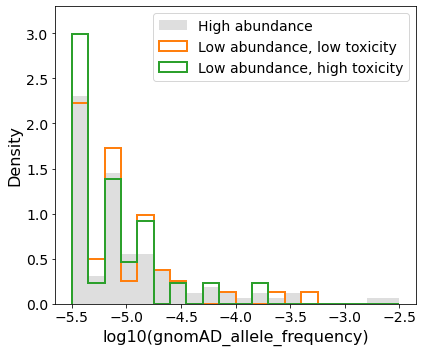

In [90]:
# plot density
plt.figure(figsize=(6,5))

n,b,p = plt.hist(x=np.log10(high_abundance_df["gnomAD_allele_frequency"]),
        range=(-5.5,-2.5),bins=20,density=True,histtype="stepfilled",linewidth=2,label="High abundance",
        color="lightgray",alpha=0.75)

plt.hist(x=np.log10(low_abundance_df[low_abundance_df["tox_group"] == "low"]["gnomAD_allele_frequency"]),
        range=(-5.5,-2.5),bins=20,density=True,histtype="step",linewidth=2,label="Low abundance, low toxicity",color="tab:orange")

plt.hist(x=np.log10(low_abundance_df[low_abundance_df["tox_group"] == "high"]["gnomAD_allele_frequency"]),
         range=(-5.5,-2.5),bins=20,density=True,histtype="step",linewidth=2,label="Low abundance, high toxicity",color="tab:green")

plt.ylim(0,3.3)
plt.xlabel("log10(gnomAD_allele_frequency)")
plt.ylabel("Density")
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig("./updated_figures/tox_gnomad_hist_density.pdf")

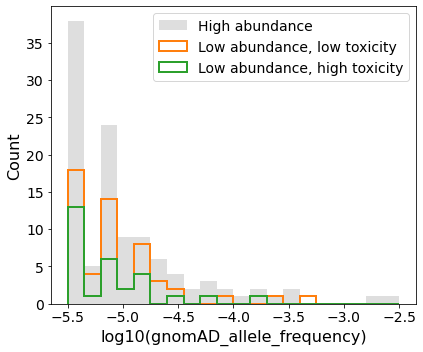

In [91]:
# plot count
plt.figure(figsize=(6,5))

n,b,p = plt.hist(x=np.log10(high_abundance_df["gnomAD_allele_frequency"]),
        range=(-5.5,-2.5),bins=20,density=False,histtype="stepfilled",linewidth=2,label="High abundance",
        color="lightgray",alpha=0.75)

plt.hist(x=np.log10(low_abundance_df[low_abundance_df["tox_group"] == "low"]["gnomAD_allele_frequency"]),
        range=(-5.5,-2.5),bins=20,density=False,histtype="step",linewidth=2,label="Low abundance, low toxicity",color="tab:orange")

plt.hist(x=np.log10(low_abundance_df[low_abundance_df["tox_group"] == "high"]["gnomAD_allele_frequency"]),
        range=(-5.5,-2.5),bins=20,density=False,histtype="step",linewidth=2,label="Low abundance, high toxicity",color="tab:green")

#plt.ylim(0,3.3)
plt.xlabel("log10(gnomAD_allele_frequency)")
plt.ylabel("Count")
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig("./updated_figures/tox_gnomad_hist_counts.pdf")

In [92]:
# estimate means, medians and error bars

In [93]:
high_abundance = np.array(high_abundance_df["gnomAD_allele_frequency"])
high_abundance = high_abundance[~np.isnan(high_abundance)]
high_abundance_log = np.log10(high_abundance)

low_abundance_low_tox = np.array(low_abundance_df[low_abundance_df["tox_group"] == "low"]["gnomAD_allele_frequency"])
low_abundance_low_tox = low_abundance_low_tox[~np.isnan(low_abundance_low_tox)]
low_abundance_low_tox_log = np.log10(low_abundance_low_tox)

low_abundance_high_tox = np.array(low_abundance_df[low_abundance_df["tox_group"] == "high"]["gnomAD_allele_frequency"])
low_abundance_high_tox = low_abundance_high_tox[~np.isnan(low_abundance_high_tox)]
low_abundance_high_tox_log = np.log10(low_abundance_high_tox)

In [94]:
data_dict = {}
i = 0

for data_arr in [high_abundance_log, low_abundance_low_tox_log, low_abundance_high_tox_log]:
    
    bootstrap_dist_mean, bootstrap_dist_median = bootstrap_mean_median(data_arr = data_arr, n_samples = 1000)

    data_dict[i] = [np.nanmean(data_arr), np.std(bootstrap_dist_mean,ddof=1), 
                    np.nanmedian(data_arr), np.std(bootstrap_dist_median,ddof=1)]
    i += 1
    
df = pd.DataFrame.from_dict(data_dict).rename(
    index={0:"mean",1:"mean_std",2:"median",3:"median_std"},
    columns={0:"high_abundance",1:"low_abundance_low_tox",2:"low_abundance_high_tox"}
)

#df.T.to_csv("./tox_gnomad_analysis_log.csv")

In [95]:
data_dict = {}
i = 0

for data_arr in [high_abundance, low_abundance_low_tox, low_abundance_high_tox]:

    data_dict[i] = [np.nanmean(data_arr), np.std(bootstrap_dist_mean,ddof=1), 
                    np.nanmedian(data_arr), np.std(bootstrap_dist_median,ddof=1)]
    i += 1
    
df = pd.DataFrame.from_dict(data_dict).rename(
    index={0:"mean",1:"mean_std",2:"median",3:"median_std"},
    columns={0:"high_abundance",1:"low_abundance_low_tox",2:"low_abundance_high_tox"}
)

#df.to_csv("./tox_gnomad_analysis.csv")